# Section: Algorithm using random placement on limited canvas
## This section provides a short explanation of the code of the algorithm
## The graphs were displayed to provide context for the alternative generation methods
## This algorithm generates the instrument panel by placing randomly the panels onto a limited canvas while prioritizing the closest position possible to the Captain

In [1]:
import sklearn as skl
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import math
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import janitor
import cairo
import random
import re
import collections
import networkx as nx
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from collections import namedtuple
from random import randint
## Cleaning imports
import hashlib
import os
import imageio
from imageio import imread
from hashlib import md5

The following statements regard the output display in Jupyter and custom named Tuples. The tuples are named "Point" to represent each co-ordinate on the canvas.

In [2]:
np.set_printoptions(threshold=sys.maxsize)

In [3]:
Point = collections.namedtuple('Point', 'x y')

It is very important that any new instrument added is included in each sheet found in the excel file. The format should be as the provided instruments.

In [4]:
df = pd.read_excel('DataFile.xlsx', sheet_name='QualitySheet')
pf = pd.read_excel('DataFile.xlsx', sheet_name='PhaseSheet')
ss = pd.read_excel('DataFile.xlsx', sheet_name='SizeSpec')
ds = pd.read_excel('DataFile.xlsx', sheet_name='SequenceSheet')
ess = pd.read_excel('DataFile.xlsx', sheet_name='EntireSequenceSheet')

### Network Graphs / Directed and Un-Directed Graphs
getFirst returns the first element of the first procedure so as to begin the graph

In [5]:
def getFirst(frames):
    iterator = frames[frames == 1].index.values
    if len(iterator) == 0:
        return findIndexUsingNum(frames, 1)
    else:
        return iterator[0]

getSize returns the size of the procedure

In [6]:
def getSize(frame):
    size = frame.size
    for f in frame:
        if(type(f) == np.str):
            for c in f:
                if(c == ','):
                    size+=1
    return size

In [7]:
def findIndexUsingNum(frames, number):
    for frame in frames:
        if(type(frame) == np.str):
            nums = re.findall('\d+', frame)
            nums = list(map(int, nums))
            if number in nums:
                 return frames[frames == frame].index.values[0]
    return None

dropProdCol is a function built to check if the column "Procedures" is still in the dataframe and removes it if so. The column serves no purpose for the creation of network graphs.

In [8]:
## Drop column from ds
def dropProdCol(dataframe):
    if 'Procedures' in dataframe.columns:
        dataframe = dataframe.drop(columns=['Procedures'])
        return dataframe
    else:
        return dataframe

In [9]:
# Remove the "Quality" Column as it serves no purpose in data
# Remove the row "Procedural Use"
def graphTransformation(df):
    totals = []
    df = df[df.Quality != 'Procedural Use']
    for col in df.columns.values:
        if(col != 'Quality'):
            totals.append(sum(df[col]))
    transformationGraph = pd.DataFrame(columns=df.columns)
    transformationGraph = transformationGraph.drop(columns=['Quality'])
    ## New list of names
    newNameList = []
    for colName in transformationGraph.columns.values:
        newNameList.append(colName+'_2')
    transformationGraph.columns = newNameList
    tot = pd.Series(totals, index=transformationGraph.columns)
    transformationGraph = transformationGraph.append(tot, ignore_index=True)
    return transformationGraph

In [10]:
# Use only for interconnected procedures
def entireGraph_Directed_withWeights(dataFrame, transformationDf):
    counter = 1
    lastUsed = 0
    transDataFrame = graphTransformation(transformationDf)
    tempGraph = nx.DiGraph()
    nodeList = dataFrame.columns.values.tolist()+transDataFrame.columns.values.tolist()
    nodeList.sort()
    tempGraph.add_nodes_from(nodeList)
    ## tying them together
    for col in dataFrame.columns:
        tempGraph.add_edge(col, col+'_2', weight=transDataFrame.iloc[0][col+'_2'])
    for index in dataFrame.index.values:
        frames = dataFrame.iloc[index]
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        for i in range(1, size+1):
            iterator = frames[frames == counter].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, counter)
                if counter != 1:
                    if res != lastUsed:
                        tempGraph.add_edge(lastUsed+'_2', res, weight=1)
                lastUsed = res
                counter +=1
            else:
                if counter != 1:
                    if iterator[0] != lastUsed:
                        tempGraph.add_edge(lastUsed+'_2', iterator[0], weight=1)
                lastUsed = iterator[0]
                counter +=1
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()
    return tempGraph

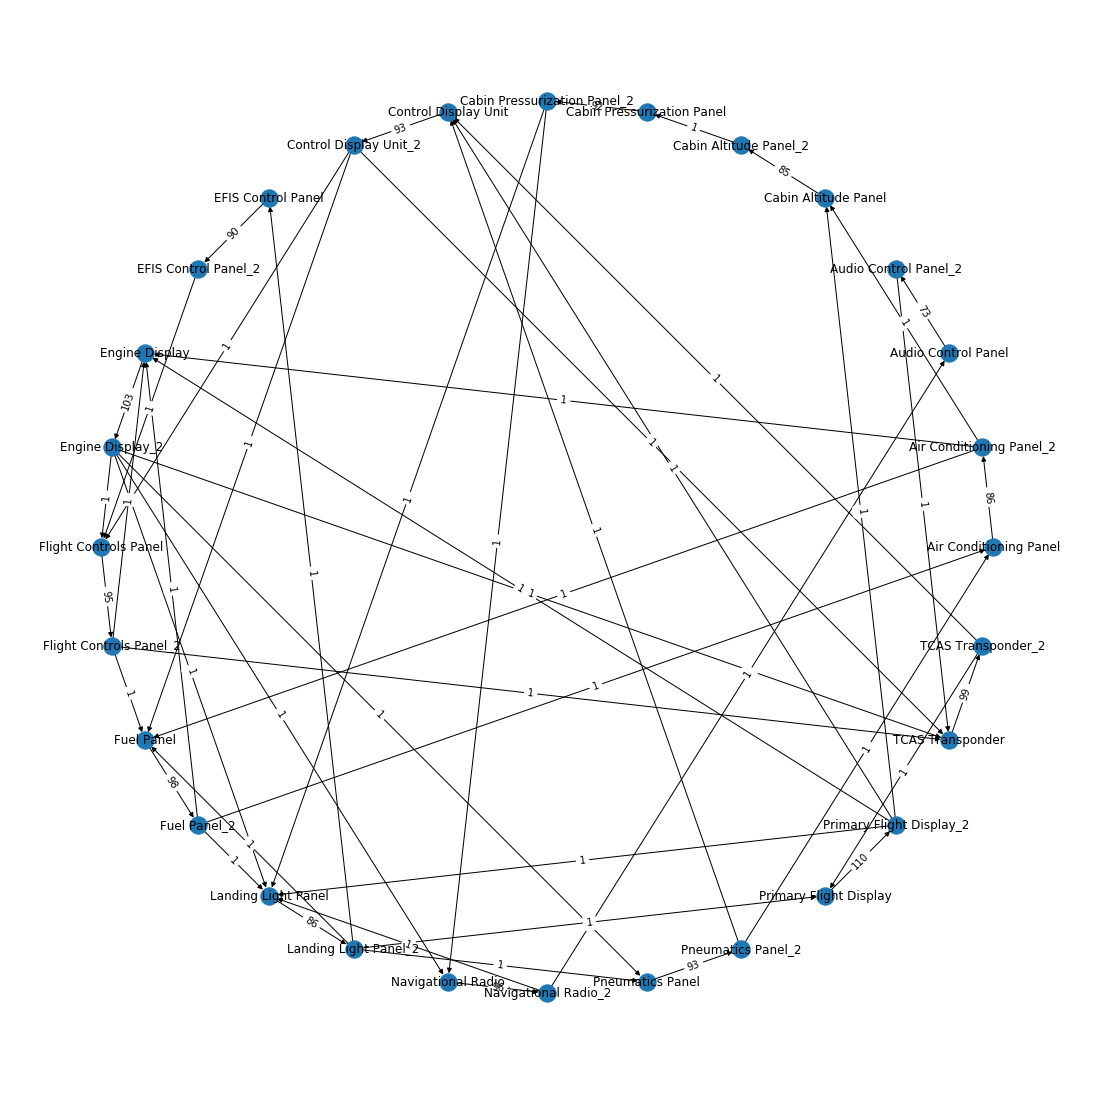

In [11]:
## Draw the entire graph with the procedures interconnected
## Directed
ess = dropProdCol(ess)
fullGraph_Directed_withWeights = entireGraph_Directed_withWeights(ess, df)

In [12]:
# Use only for sequence only
def drawFullDetailedDirectedGraphs_withWeights(dataFrame, transformationDf):
    counter = 1
    lastUsed = 0
    transDataFrame = graphTransformation(transformationDf)
    tempGraph = nx.DiGraph()
    nodeList = dataFrame.columns.values.tolist()+transDataFrame.columns.values.tolist()
    nodeList.sort()
    tempGraph.add_nodes_from(nodeList)
    ## tying them together
    for col in dataFrame.columns:
        tempGraph.add_edge(col, col+'_2', weight=transDataFrame.iloc[0][col+'_2'])
    for index in dataFrame.index.values:
        frames = dataFrame.iloc[index]
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        lastUsed = getFirst(frames)
        for i in range(1, size+1):
            iterator = frames[frames == i].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, i)
                if counter != 1:
                    if res != lastUsed:
                        tempGraph.add_edge(lastUsed+'_2', res, weight=1)
                lastUsed = res
                counter +=1
            else:
                if counter != 1:
                    if iterator[0] != lastUsed:
                        tempGraph.add_edge(lastUsed+'_2', iterator[0], weight=1)
                lastUsed = iterator[0]
                counter +=1
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()
    return tempGraph

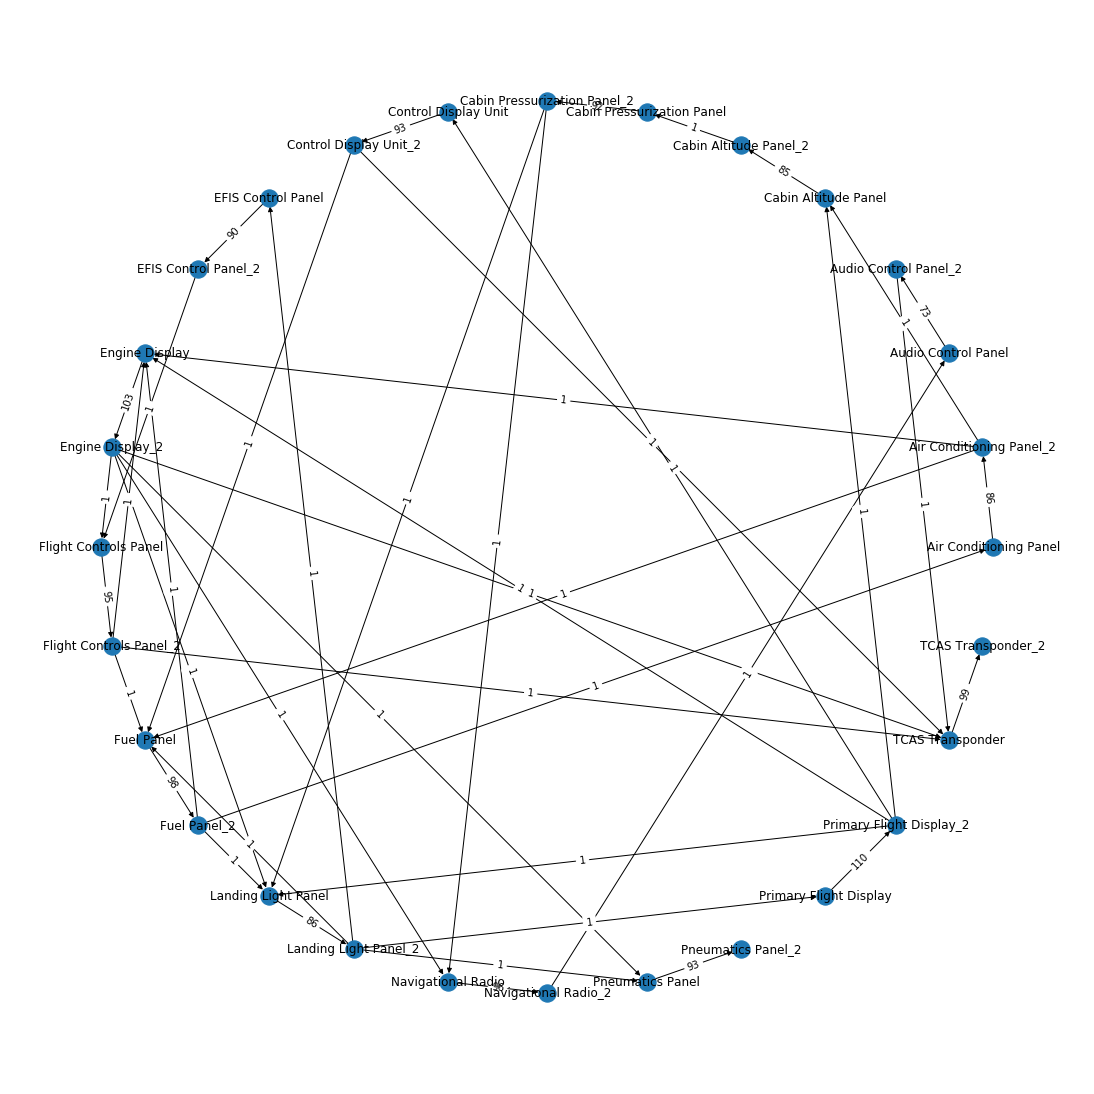

In [13]:
## Drawing full directed graph with weights- one large diagram
## ALl nodes are connected according to sequence only
ds = dropProdCol(ds)
procedureOnly_DirectedGraph_Full_Weighted = drawFullDetailedDirectedGraphs_withWeights(ds, df)

The value '2' is the identifer of the exit node of an instrument. For example CPU is the input and CPU2 is the output. What this algorithm does is that it creates the list in the correct traversal order, but it removes all mention of the exit nodes.

In [14]:
def getCleanList_Tuple(dirtyTupleList):
    cleanList = []
    for item in dirtyTupleList:
        (val1, val2) = item
        if "2" not in val1 and val1 not in cleanList:
            cleanList.append(val1)
        if "2" not in val2 and val2 not in cleanList:
            cleanList.append(val2)
    return cleanList

The purpose of this function is to find the very first node of the graph, the starting node. This will ensure that regardless of the traversal algorithm used, both algorithms start from the same point.

In [15]:
def getFirstAsSource(dataFrame):
    answer = dataFrame.iloc[0]
    ans = answer[answer == 1].index[0]
    return ans

The following four algorithms retreive the edge nodes from the graphs using their respective traversal algorithms of Breadth first search and depth first search. It is important for all nodes to be 'cleaned' afterwards, removing the exit nodes labelled with '\_2' in order to only list instruments.

In [16]:
## Depth First search on procedural only, directed graph, full
dfs_tree_procedureOnly_DirectedGraph_Full_Weighted = nx.dfs_edges(procedureOnly_DirectedGraph_Full_Weighted, source=getFirstAsSource(ess))
clean_dfs_list_procedureOnly_DirectedGraph_Full_Weighted = getCleanList_Tuple(list(dfs_tree_procedureOnly_DirectedGraph_Full_Weighted))

In [17]:
## Breath First search on procedural only, directed graph, full
bfs_tree_procedureOnly_DirectedGraph_Full_Weighted = nx.bfs_edges(procedureOnly_DirectedGraph_Full_Weighted, source=getFirstAsSource(ess))
clean_bfs_list_procedureOnly_DirectedGraph_Full_Weighted = getCleanList_Tuple(list(bfs_tree_procedureOnly_DirectedGraph_Full_Weighted))

In [18]:
## Depth First search on start to finish, directed graph, full
dfs_tree_fullGraph_Directed_withWeights = nx.dfs_edges(fullGraph_Directed_withWeights, source=getFirstAsSource(ess))
clean_dfs_list_fullGraph_Directed_withWeights = getCleanList_Tuple(list(dfs_tree_fullGraph_Directed_withWeights))

In [19]:
## Breath First search on start to finish, directed graph, full
bfs_tree_fullGraph_Directed_withWeights = nx.dfs_edges(fullGraph_Directed_withWeights, source=getFirstAsSource(ess))
clean_bfs_list_fullGraph_Directed_withWeights = getCleanList_Tuple(list(bfs_tree_fullGraph_Directed_withWeights))

### Algorithm: Based on generating instrumentation on a limitied canvas depecting the space allowed for insturmentation in the cockpit
##### This algorithm places instrumentation randomly, ordered by the attribute "Procedural Use" or a graph traversal algorithm
##### The generation prioritizes the closest possible coordinate to the pilot
##### The algorithm is then adapted to use graph traversal algorithms Breadth and Depth First Search

In [20]:
## Creating pandas dataframe: 1 row for each instrument with the following parameters;
# Name,TotalAttributes,ProceduralUse,Height,Width
# 4 columns added later for points AboveRight,AboveLeft,UnderRight,UnderLeft
def dataFrameCreation(pd, df):
    instFrame = pd.DataFrame(columns=['Name', 'TotalAttributes',
                                      'ProceduralUse', 'Height',
                                      'Width', 'AboveRight',
                                      'AboveLeft','UnderRight',
                                      'UnderLeft', 'Colour'])
    columnList = df.columns.values.tolist()
    columnList.remove('Quality')
    for inst in columnList:
        instFrame = instFrame.append({'Name': inst, 'TotalAttributes': df[inst].sum(),
                                      'ProceduralUse': pf[inst].sum(),
                                      'Height':ss.loc[ss.Instrument == inst]['Height'].values[0],
                                      'Width' :ss.loc[ss.Instrument == inst]['Width'].values[0],
                                     'AboveRight': 0,
                                     'AboveLeft': 0,
                                     'UnderRight': 0,
                                     'UnderLeft': 0},
                                     ignore_index=True)
    return instFrame

colGen and colPick are methods accessed by the drawing algorithm to select a unique colour.

In [21]:
## Generate Colours
def colGen():
    ## 100 colours
    colourList = []
    for i in range (100):
        colour = (randint(99,255)/255.0,randint(99,255)/255.0,randint(99,255)/255.0)
        while colour not in colourList:
            colour = (randint(99,255)/255.0,randint(99,255)/255.0,randint(99,255)/255.0)
            colourList.append(colour)
    return colourList

In [22]:
## Colour Picker
def colPick(canvas):
    colourList = canvas.getColList()
    picked = random.choice(colourList)
    colourList.remove(picked)
    canvas.setColList(colourList)
    return picked

The python library called "Cairo" is used in order to generate the panels.

In [23]:
## Art Canvas ##
class Canvas:
    
    def __init__(self):
        self.colourList = []
        self.paintWidth = 1700
        self.paintHeight = 2600
        self.ims = cairo.ImageSurface(cairo.FORMAT_ARGB32, self.paintWidth, self.paintHeight)
        self.cr = cairo.Context(self.ims)
    
    def getCanvasWidth(self):
        return self.paintWidth
    
    def getCanvasHeight(self):
        return self.paintHeight
    
    def getCr(self):
        return self.cr
    
    def setColList(self, colList):
        self.colourList = colList
        
    def getColList(self):
        return self.colourList

The Store class is tasked with the storage of all coordinates which are used in the drawing.

In [24]:
class Store():
       
    def __init__(self):
        self.PointListCovered = set()
        self.AllowedList = set()
        self.UserLocation = 0
        self.differenceStorage = 0
        self.Separators = []
    
    def getPointList(self):
        return self.PointListCovered
    
    def setPointList(self, newList):
        self.PointListCovered = newList
        
    def getAllowedList(self):
        return self.AllowedList
    
    def setAllowedList(self, newList):
        self.AllowedList = newList
        
    def getUserLocation(self):
        return self.UserLocation
    
    def setUserLocation(self, newCo):
        self.UserLocation = newCo
        
    def getDifference(self):
        return self.differenceStorage
    
    def setDifference(self, diff):
        self.differenceStorage = diff
        
    def getSeparators(self):
        return self.Separators
    
    def setSeparators(self, new):
        self.Separators = new

pointStorage is a function which stores all the coordinates and those between said coordinates into the store.

In [25]:
## Store all points used and save
## The +1 was added because of iterator range stopping short of the last coordinate
def pointStorage(bottomLeft, bottomRight, topLeft, topRight, storage):
    PointListCovered = storage.getPointList()
    (bottomLeftX, bottomLeftY) = bottomLeft
    (bottomRightX, bottomRightY) = bottomRight
    (topLeftX, topLeftY) = topLeft
    (topRightX, topRightY) = topRight
    for i in range(topLeftX, topRightX+1):
        for y in range(topRightY, bottomRightY+1):
            PointListCovered.add(Point(i, y))
    storage.setPointList(PointListCovered)

canvasAllowed checks if the coordinates to be drawn are within the allowed size of the canvas.

In [26]:
## Store canvas area which is allowed to be used
## The +1 was added because of iterator range stopping short of the last coordinate
def canvasAllowed(bottomLeft, bottomRight, topLeft, topRight, storage):
    separators = storage.getSeparators()
    tempSet = set()
    canvasCovered = storage.getAllowedList()
    (bottomLeftX, bottomLeftY) = bottomLeft
    (bottomRightX, bottomRightY) = bottomRight
    (topLeftX, topLeftY) = topLeft
    (topRightX, topRightY) = topRight
    for i in range(topLeftX, topRightX+1):
        for y in range(topRightY, bottomRightY+1):
            canvasCovered.add(Point(i, y))
            tempSet.add(Point(i,y))
    separators.append(tempSet)
    storage.setSeparators(separators)
    storage.setAllowedList(canvasCovered)

I have no idea what this does, I did forget. The check seems to be useless because getAllowedList does the same thing.
But my fear and the time it takes to compile this algorithm (4 hours) does not make it suitable for configuration yet.

In [27]:
def sepCheck(bottomLeft, bottomRight, topLeft, topRight, storage):
    separators = storage.getSeparators()
    for sepSet in separators:
        if bottomLeft in sepSet and bottomRight in sepSet and topLeft in sepSet and topRight in sepSet:
            return True
    return False

This function will ensure that the check is done correctly. This is guranteed to take O(n) time. It is required, do not remove.

In [28]:
def coUncertaintyCheck(bottomLeft, bottomRight, topLeft, topRight, storage):
    pointList = storage.getPointList()
    (bottomLeftX, bottomLeftY) = bottomLeft
    (bottomRightX, bottomRightY) = bottomRight
    (topLeftX, topLeftY) = topLeft
    (topRightX, topRightY) = topRight
    for i in range(topLeftX, topRightX+1):
        for y in range(topRightY, bottomRightY+1):
            if Point(i,y) in pointList:
                ## If true is returned, then it means there is a coordinate between these coordinates which is already used
                return True
    ## If False is returned, then the coordinates have been checked thoroughly and nothing was found to match
    return False

coCycle randomly picks which direction the instrument is to be drawn. It checks if it allowed to draw in that direction first.

In [29]:
# Find me a point in which this instrument can fit in
def coCycle(width, height, storage):
    diffStore = storage.getDifference()
    # Iterate over every row
    for index, row in diffStore.iterrows():
        x = int(row['X'])
        y = int(row['Y'])
        if Point(x,y) not in storage.getPointList():
            ## Pick direction at random
            randomPoint = [0, 1, 2, 3]
            random.shuffle(randomPoint)
            for i in randomPoint:
                if i == 0:
                    ## NE
                    bottomLeft = Point(x,y)
                    bottomRight = Point(x+width,y)
                    topLeft = Point(x,y-height)
                    topRight = Point(x+width,y-height)
                    
                    if (bottomLeft not in storage.getPointList() and bottomRight not in storage.getPointList() and topLeft not in storage.getPointList() and topRight not in storage.getPointList()
                    and bottomLeft in storage.getAllowedList() and bottomRight in storage.getAllowedList() and topLeft in storage.getAllowedList() and topRight in storage.getAllowedList()
                       and sepCheck(bottomLeft,bottomRight,topLeft,topRight,storage) == True and coUncertaintyCheck(bottomLeft, bottomRight, topLeft, topRight, storage) == False):
                        return bottomLeft, bottomRight, topLeft, topRight
                if i == 1:
                    ## NW
                    bottomLeft = Point(x-width,y)
                    bottomRight = Point(x,y)
                    topLeft = Point(x-width,y-height)
                    topRight = Point(x,y-height)
                    
                    if (bottomLeft not in storage.getPointList() and bottomRight not in storage.getPointList() and topLeft not in storage.getPointList() and topRight not in storage.getPointList()
                    and bottomLeft in storage.getAllowedList() and bottomRight in storage.getAllowedList() and topLeft in storage.getAllowedList() and topRight in storage.getAllowedList()
                       and sepCheck(bottomLeft,bottomRight,topLeft,topRight,storage) == True and coUncertaintyCheck(bottomLeft, bottomRight, topLeft, topRight, storage) == False):
                        return bottomLeft, bottomRight, topLeft, topRight
                if i == 2:
                    ## SW
                    bottomLeft = Point(x-width,y+height)
                    bottomRight = Point(x,y+height)
                    topLeft = Point(x-width,y)
                    topRight = Point(x,y)
                    
                    if (bottomLeft not in storage.getPointList() and bottomRight not in storage.getPointList() and topLeft not in storage.getPointList() and topRight not in storage.getPointList()
                        and bottomLeft in storage.getAllowedList() and bottomRight in storage.getAllowedList() and topLeft in storage.getAllowedList() and topRight in storage.getAllowedList()
                       and sepCheck(bottomLeft,bottomRight,topLeft,topRight,storage) == True and coUncertaintyCheck(bottomLeft, bottomRight, topLeft, topRight, storage) == False):
                        return bottomLeft, bottomRight, topLeft, topRight
                if i == 3:
                    ## SE
                    bottomLeft = Point(x,y+height)
                    bottomRight = Point(x+width,y+height)
                    topLeft = Point(x,y)
                    topRight = Point(x+width,y)
                    
                    if (bottomLeft not in storage.getPointList() and bottomRight not in storage.getPointList() and topLeft not in storage.getPointList() and topRight not in storage.getPointList() 
                        and bottomLeft in storage.getAllowedList() and bottomRight in storage.getAllowedList() and topLeft in storage.getAllowedList() and topRight in storage.getAllowedList()
                       and sepCheck(bottomLeft,bottomRight,topLeft,topRight,storage) == True and coUncertaintyCheck(bottomLeft, bottomRight, topLeft, topRight, storage) == False):
                        return bottomLeft, bottomRight, topLeft, topRight

The task of resetCo is to ensure that the dataFrame coordinates have been reset to 0 so the algorithm can generate a new panel using the same method with random parameters.

In [30]:
## Method to reset coordinates for redrawn
def resetCO(instFrame):
    for index in instFrame.index:
        instFrame.at[index, 'UnderLeft'] = 0
        instFrame.at[index, 'UnderRight'] = 0
        instFrame.at[index, 'AboveLeft'] = 0
        instFrame.at[index, 'AboveRight'] = 0
    return instFrame

legendDraw is simply tasked with drawing the legend/key of the instrument panels containing which colours are assigned to what instrument.

In [31]:
## Legend Artist
def legendDraw(instFrame):
    ## Create canvas
    ims = cairo.ImageSurface(cairo.FORMAT_ARGB32, 2000, 2000)
    cr = cairo.Context(ims)
    x1 = 1000
    y1 = 500
    x2 = 1200
    x3 = 1250
    for index in instFrame.index:
        tempFrame = instFrame.loc[[index]]
        (r,g,b) = tempFrame['Colour'].values[0]
        cr.set_source_rgb(r,g,b)
        cr.move_to(x1,y1)
        cr.line_to(x2,y1)
        cr.set_line_width(19)
        cr.stroke()
        cr.move_to(x3,y1)
        cr.set_source_rgb(0, 0, 0)
        cr.set_font_size(25)
        cr.select_font_face("Arial",
                     cairo.FONT_SLANT_NORMAL,
                     cairo.FONT_WEIGHT_BOLD)
        cr.show_text(tempFrame.Name.values[0])
        y1 = y1 + 100
    ims.write_to_png('Legend.png')

Draws the canvas on which the instrument panel is to be drawn.

In [32]:
## This has to be custom made to fit
def drawCockpitCanvas(canvas, storage):
    cr = canvas.getCr()
    cr.set_source_rgb(0, 0, 0)
    # forward and aft overhead panel
    cr.move_to(550, 0)
    cr.line_to(1220,0)
    cr.line_to(1220,1045)
    cr.line_to(550,1045)
    cr.line_to(550,0)
    cr.close_path()
    cr.set_source_rgb(0,0,0)
    cr.set_line_width(7)
    cr.stroke()
    ## bottom left - bottom right- top left - top right
    canvasAllowed(Point(550,1045), Point(1220,1045), Point(550,0), Point(1220,0), storage)
    # glareshield
    cr.move_to(550,1046)
    cr.line_to(427,1046)
    cr.line_to(427,1121)
    cr.line_to(1342,1121)
    cr.line_to(1342,1046)
    cr.line_to(550,1046)
    cr.set_source_rgb(0, 0, 0)
    cr.set_line_width(7)
    cr.stroke()
    canvasAllowed(Point(427,1121), Point(1342,1121), Point(427,1046), Point(1342,1046), storage)
    # main panel - top
    cr.move_to(427,1122)
    cr.line_to(127,1122)
    cr.line_to(127,1567)
    cr.line_to(1642,1567)
    cr.line_to(1642,1122)
    cr.line_to(427,1122)
    cr.set_source_rgb(0, 0, 0)
    cr.set_line_width(7)
    cr.stroke()
    canvasAllowed(Point(127,1567), Point(1642,1567), Point(127,1122), Point(1642,1122), storage)
    # main panel - low
    cr.move_to(627,1568)
    cr.line_to(627,1703)
    cr.line_to(1142,1703)
    cr.line_to(1142,1568)
    cr.line_to(627,1568)
    cr.set_source_rgb(0, 0, 0)
    cr.set_line_width(7)
    cr.stroke()
    canvasAllowed(Point(627,1703), Point(1142,1703), Point(627,1568), Point(1142,1703), storage)
    # throttle quadrant
    cr.move_to(988,1704)
    cr.line_to(781,1704)
    cr.line_to(781,1942)
    cr.line_to(988, 1942)
    cr.line_to(988, 1704)
    cr.set_source_rgb(0, 0, 0)
    cr.set_line_width(7)
    cr.stroke()
    # NOTHING IS TO TAKE THE SPACE USED BY PHYSICAL CONTROL instruments - leave this commented out
    #canvasAllowed(Point(781,1942), Point(988,1942), Point(781,1704), Point(988,1704), storage)
    # pedestal
    cr.move_to(1112,1943)
    cr.line_to(1112,2506)
    cr.line_to(657,2506)
    cr.line_to(657,1943)
    cr.line_to(1112,1943)
    cr.set_source_rgb(0, 0, 0)
    cr.set_line_width(7)
    cr.stroke()
    canvasAllowed(Point(657,2506), Point(1112,2506), Point(657,1943), Point(1112,1943), storage)
    ## Place Captain and First Officer
    ## Captain 
    midpointCx = int(math.floor((657+127)/2))
    midpointCy = int(math.floor((2506+1122)/2))
    cr.arc(midpointCx, midpointCy, 100, 0, 2*math.pi)
    cr.close_path()
    cr.set_source_rgb(0,0,0)
    cr.set_line_width(7)
    cr.stroke()
    storage.setUserLocation(Point(midpointCx,midpointCy))
    ## First Officer
    midpointCx = int(math.floor((1112+1642)/2))
    midpointCy = int(math.floor((2506+1122)/2))
    cr.arc(midpointCx, midpointCy, 100, 0, 2*math.pi)
    cr.close_path()
    cr.set_source_rgb(0,0,0)
    cr.set_line_width(7)
    cr.stroke()

These two methods are used in calculating the starting point.

In [33]:
## Distance Formula
def distFormula(series, user):
    (x2, y2) = user
    x = math.pow(x2-series['X'],2)
    y = math.pow(y2-series['Y'],2)
    return math.sqrt(x+y)

In [34]:
## Method which calculates the distance between the pilots and the point
def distCalc(storage):
    diffPd = pd.DataFrame(storage.getAllowedList(), columns=['X', 'Y'])
    userLoc = storage.getUserLocation()
    diffPd['Difference'] = diffPd.apply(distFormula, axis=1, user=userLoc)
    diffPd = diffPd.sort_values(by=['Difference'], ascending=True)
    storage.setDifference(diffPd)      

newArtist is tasked with drawing the instrument and picking a random colour.

In [35]:
def newArtist(toDraw, instFrame, singleFrame, canvas, storage):
    #print("CALLED TO DRAW: ", instrument.index.values[0])
    cr = canvas.getCr()
    
    (bottomLeft, bottomRight, topLeft, topRight) = toDraw
    
    ## Store the coordinates in the pandas dataframe original
    instFrame.at[singleFrame.index.values[0], 'UnderLeft'] = bottomLeft
    instFrame.at[singleFrame.index.values[0], 'UnderRight'] = bottomRight
    instFrame.at[singleFrame.index.values[0], 'AboveLeft'] = topLeft
    instFrame.at[singleFrame.index.values[0], 'AboveRight'] = topRight
    
    ## Store the tuples to be covered
    pointStorage(bottomLeft, bottomRight, topLeft, topRight, storage)
    ## Now to draw
    (x1,y1) = bottomLeft
    (x2,y2) = bottomRight
    (x3,y3) = topLeft
    (x4,y4) = topRight
    
    cr.move_to(x1,y1)
    cr.line_to(x2,y2)
    cr.line_to(x4,y4)
    cr.line_to(x3,y3)
    cr.line_to(x1,y1)
    cr.close_path()
    
    if singleFrame['Colour'].isnull().values:
        (r,g,b) = colPick(canvas)
        instFrame.at[singleFrame.index.values[0], 'Colour'] = (r,g,b)
    else:
        (r,g,b) = singleFrame['Colour'].values[0]
    cr.set_source_rgb(r,g,b)
    cr.fill_preserve()
    cr.stroke()
    
    return instFrame

In [36]:
def locationMain(indexNumber, allFrames, canvas, storage):
    ## Take width and height
    tempFrame = allFrames.loc[[indexNumber]]
    ## Call method to find the point which can be used
    points = coCycle(int(tempFrame['Width']), int(tempFrame['Height']), storage)
    modifiedFrame = newArtist(points, allFrames, tempFrame, canvas, storage)
    return modifiedFrame

This algorithm uses "Procedural Use" attribute to determine in which order to generate the instrumentation.

In [37]:
## Main Method Algorithm ##
instFrame = dataFrameCreation(pd, df)
instFrame = instFrame.sort_values(by=['ProceduralUse'], ascending=False)
for x in range(20):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    drawCockpitCanvas(canvas, storage)
    distCalc(storage)    
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = locationMain(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
        
    canvas.ims.write_to_png('Normal_Procedural_'+str(x)+'.png')
legendDraw(instFrame)

This algorithm uses Breadth first search on a graph which plots with accordance to the procedures only.

In [38]:
## Sorted - full directed graph from procedure only BFS version
instFrame['Name'] = pd.Categorical(instFrame['Name'], clean_bfs_list_procedureOnly_DirectedGraph_Full_Weighted)
instFrame = instFrame.sort_values('Name')
for x in range(20):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    drawCockpitCanvas(canvas, storage)
    distCalc(storage)    
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = locationMain(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
    canvas.ims.write_to_png('Procedural_Full_Weighted_BFS_'+str(x)+'.png')
legendDraw(instFrame)

This algorithm uses depth first search on a graph which plots with accordance to the procedures only.

In [39]:
## Sorted - full directed graph from procedure only DFS version
instFrame['Name'] = pd.Categorical(instFrame['Name'], clean_dfs_list_procedureOnly_DirectedGraph_Full_Weighted)
instFrame = instFrame.sort_values('Name')
for x in range(20):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    drawCockpitCanvas(canvas, storage)
    distCalc(storage)    
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = locationMain(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
    canvas.ims.write_to_png('Procedural_Weighted_DFS_'+str(x)+'.png')
legendDraw(instFrame)

This algorithm uses breath first search on a graph which plots with from the first instrument used in the first procedure, straight to the last instrument used in the last procedure.

In [40]:
## Sorted - full directed graph from start to finish BFS version
instFrame['Name'] = pd.Categorical(instFrame['Name'], clean_bfs_list_fullGraph_Directed_withWeights)
instFrame = instFrame.sort_values('Name')
for x in range(20):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    drawCockpitCanvas(canvas, storage)
    distCalc(storage)    
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = locationMain(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
    canvas.ims.write_to_png('SF_Full_Weighted_BFS_'+str(x)+'.png')
legendDraw(instFrame)

This algorithm uses breath first search on a graph which plots with from the first instrument used in the first procedure, straight to the last instrument used in the last procedure.

In [41]:
## Sorted - full directed graph from start to finish DFS version
instFrame['Name'] = pd.Categorical(instFrame['Name'], clean_dfs_list_fullGraph_Directed_withWeights)
instFrame = instFrame.sort_values('Name')
for x in range(20):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    drawCockpitCanvas(canvas, storage)
    distCalc(storage)    
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = locationMain(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
    canvas.ims.write_to_png('SF_Full_Weighted_DFS_'+str(x)+'.png')
legendDraw(instFrame)

#### Cleaning the duplicate images using hashing

In [42]:
files_list = os.listdir()
duplicates = []
hash_keys = dict()
for index, filename in enumerate(os.listdir('.')): # . means current directory
    if os.path.isfile(filename):
        with open(filename, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash not in hash_keys:
            hash_keys[filehash] = index
        else:
            duplicates.append((index,hash_keys[filehash]))

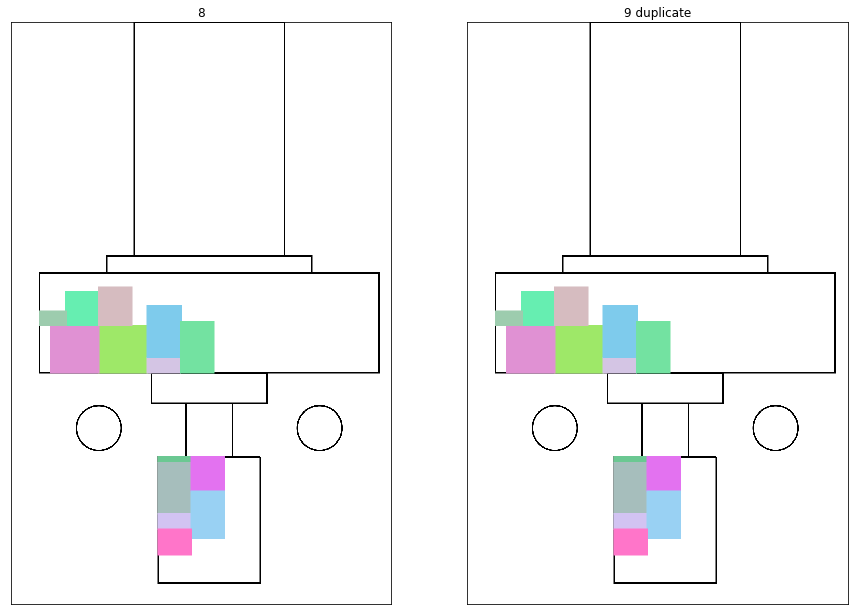

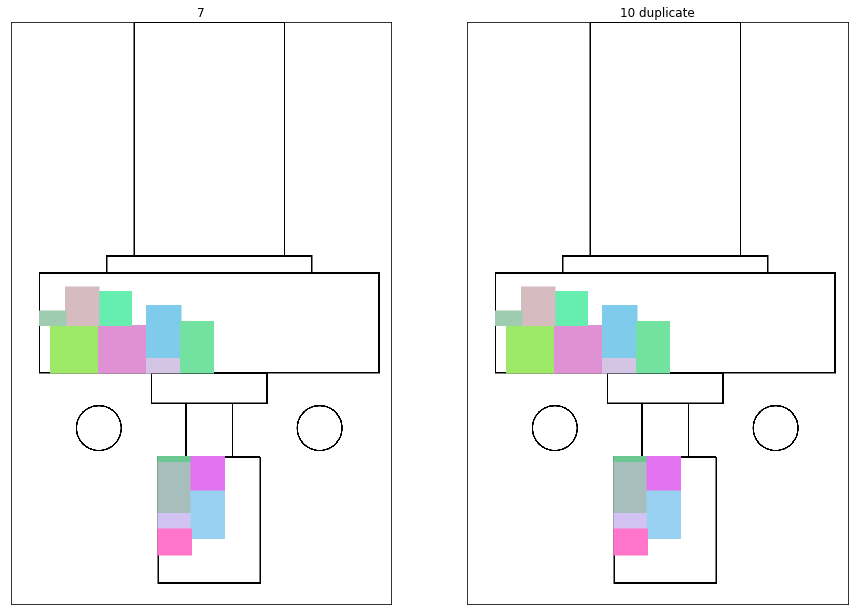

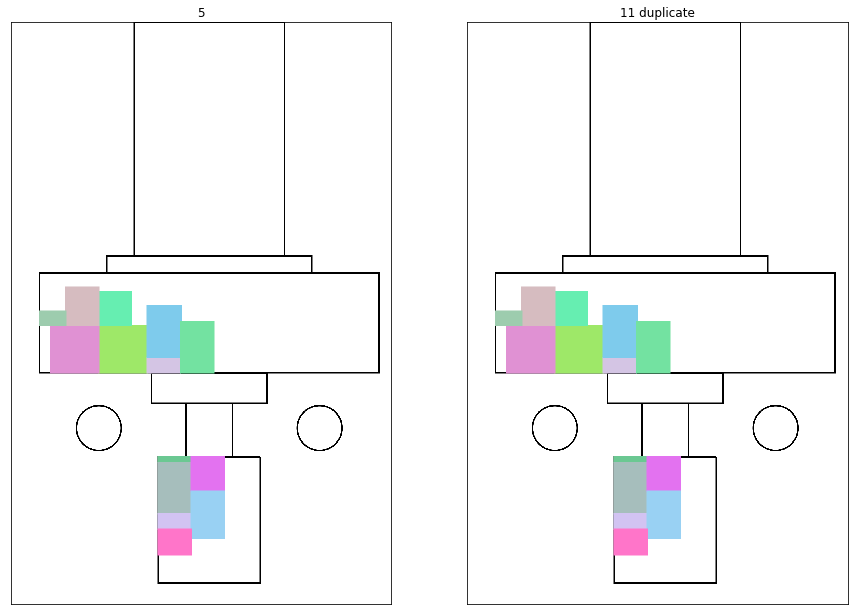

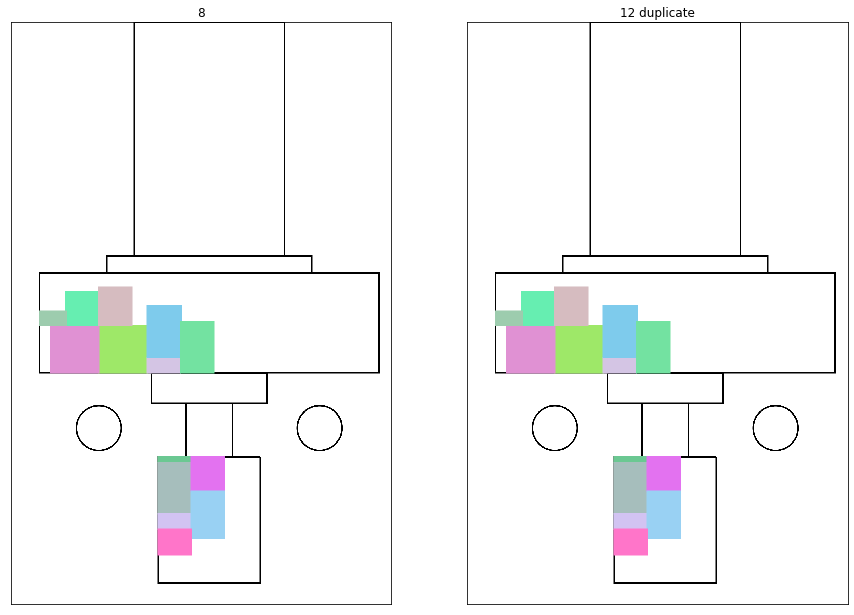

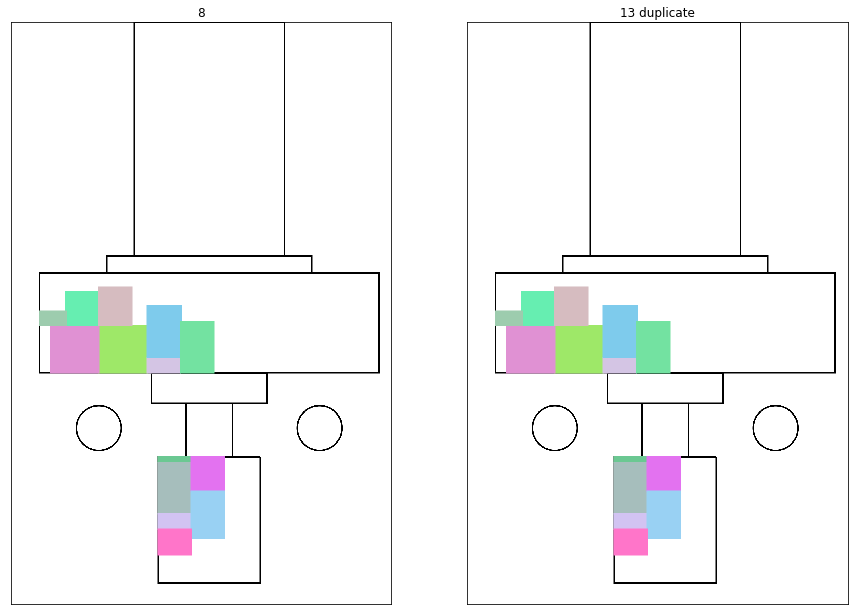

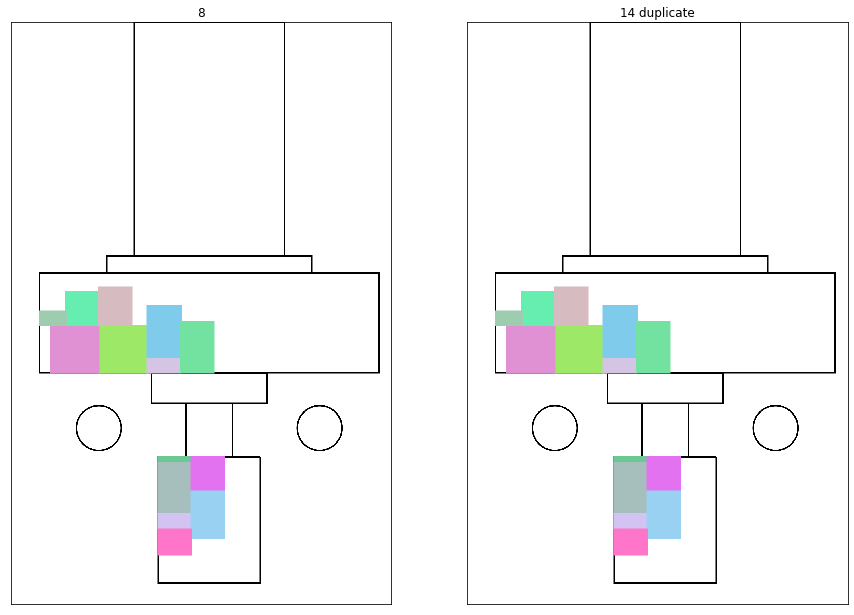

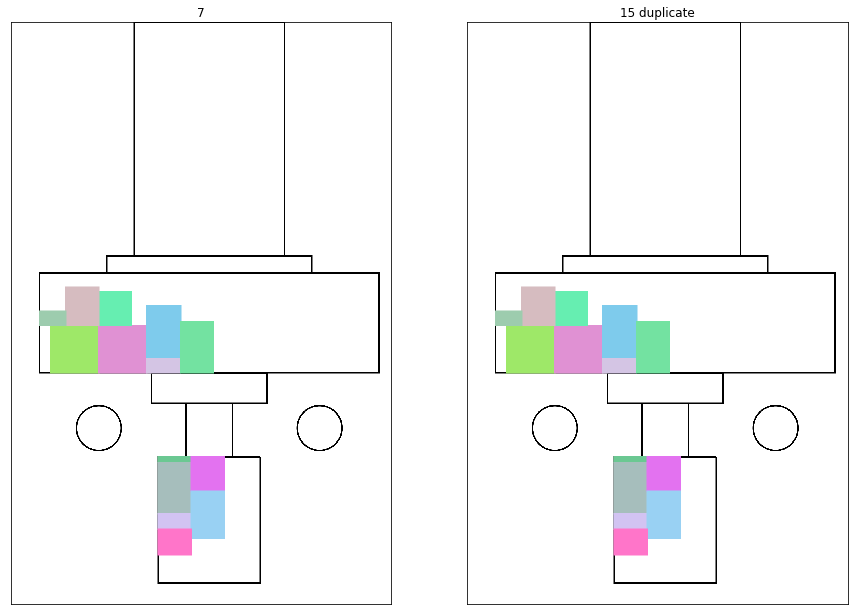

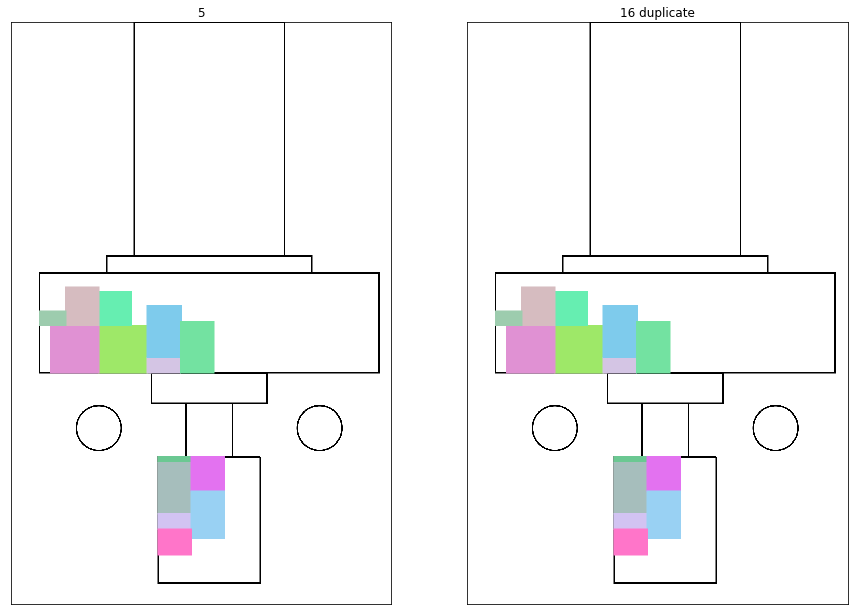

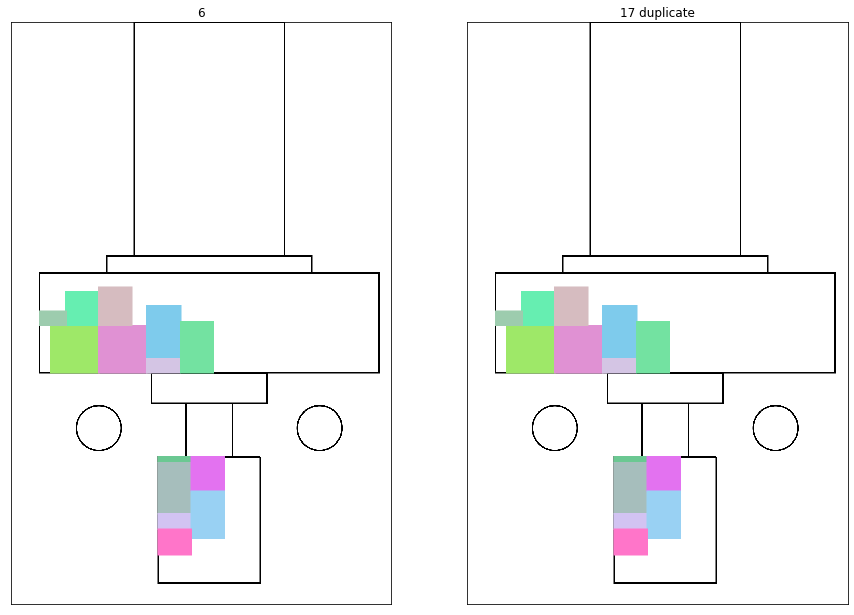

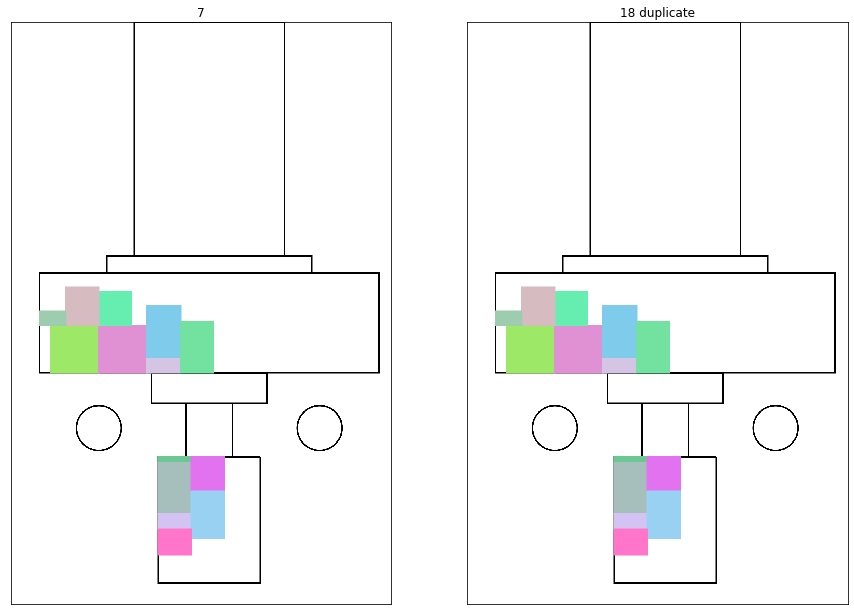

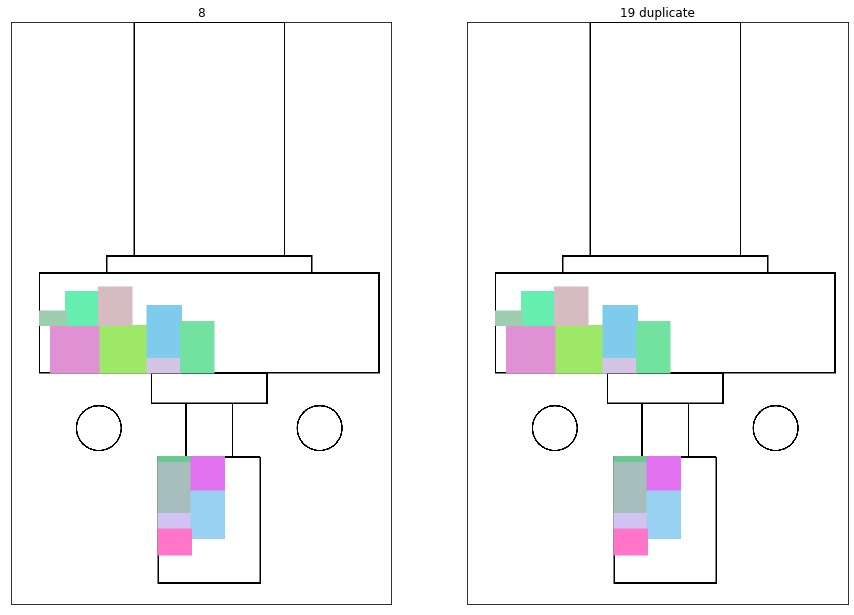

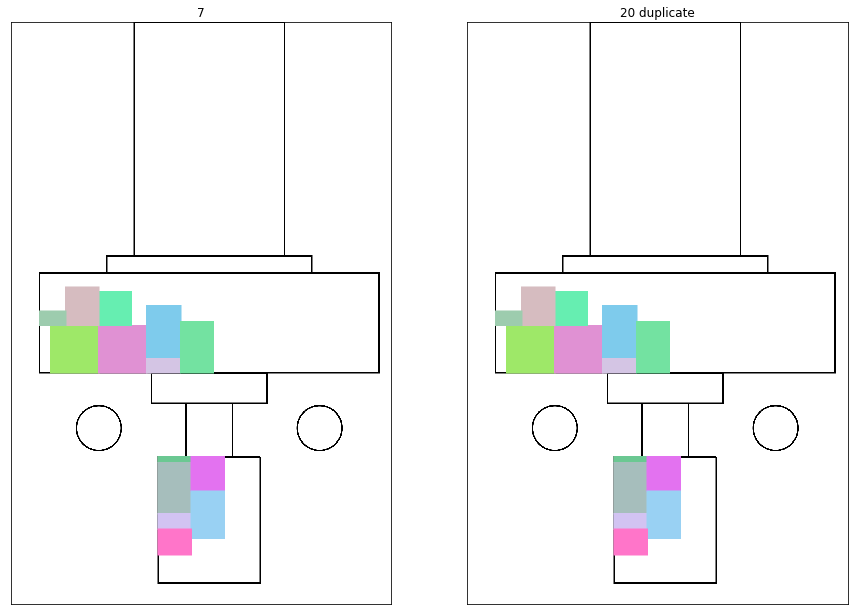

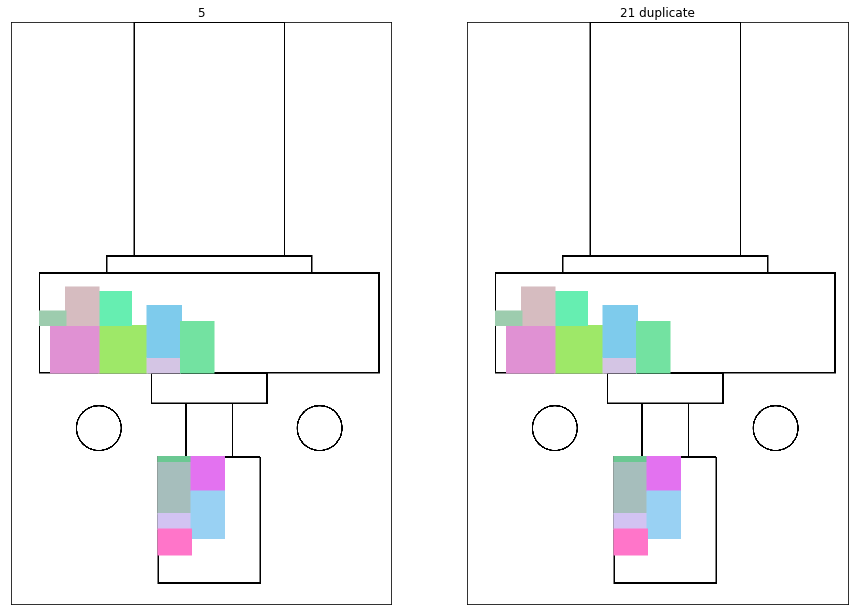

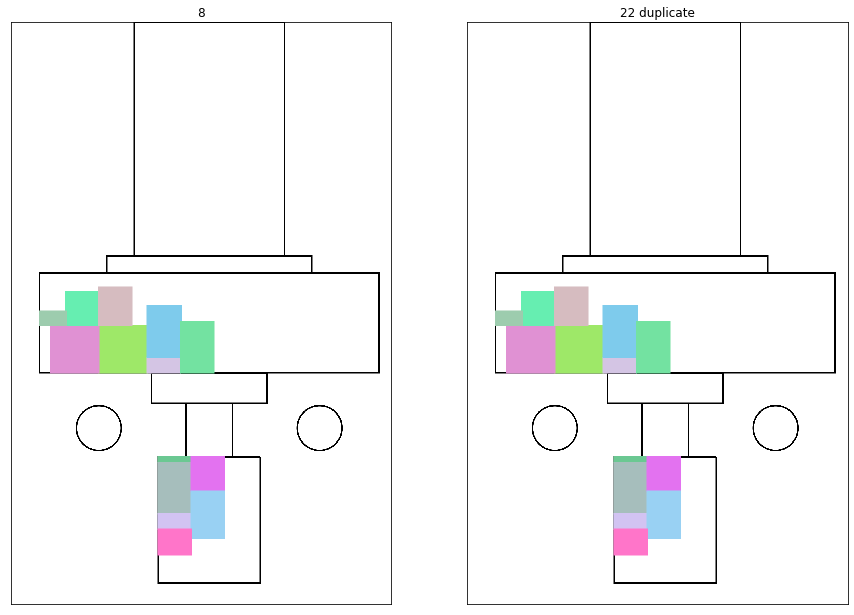

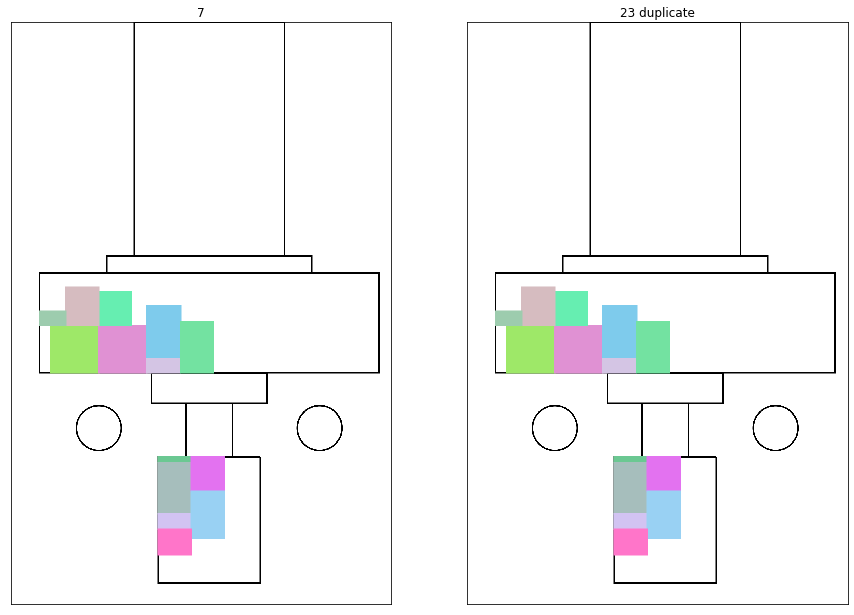

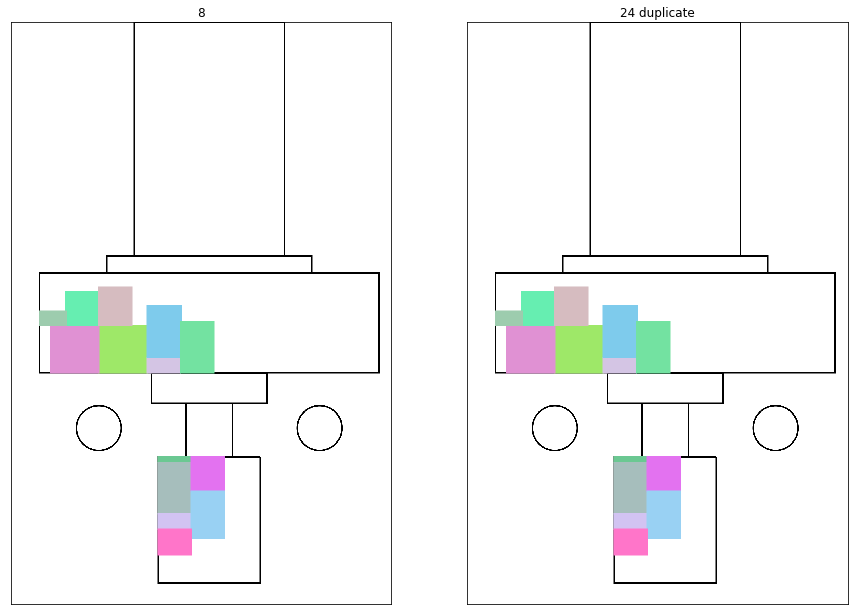

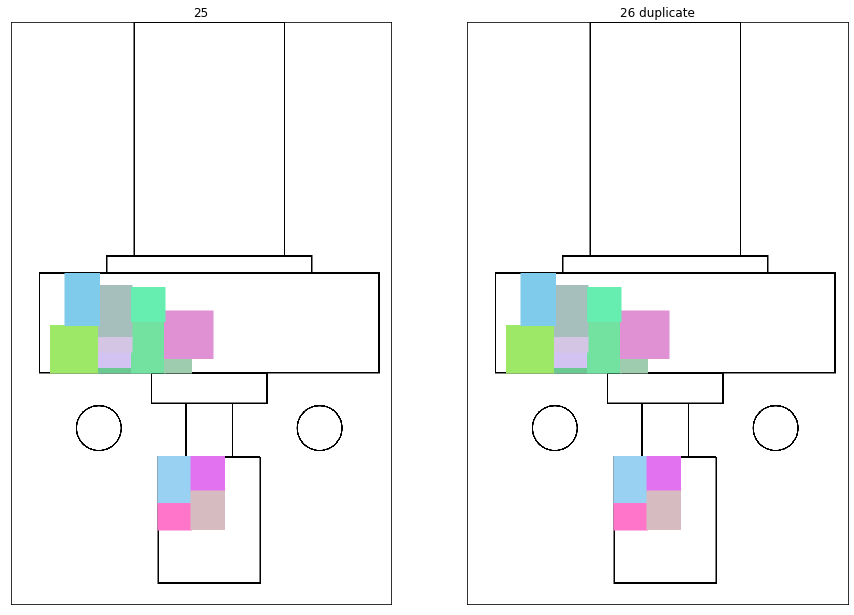

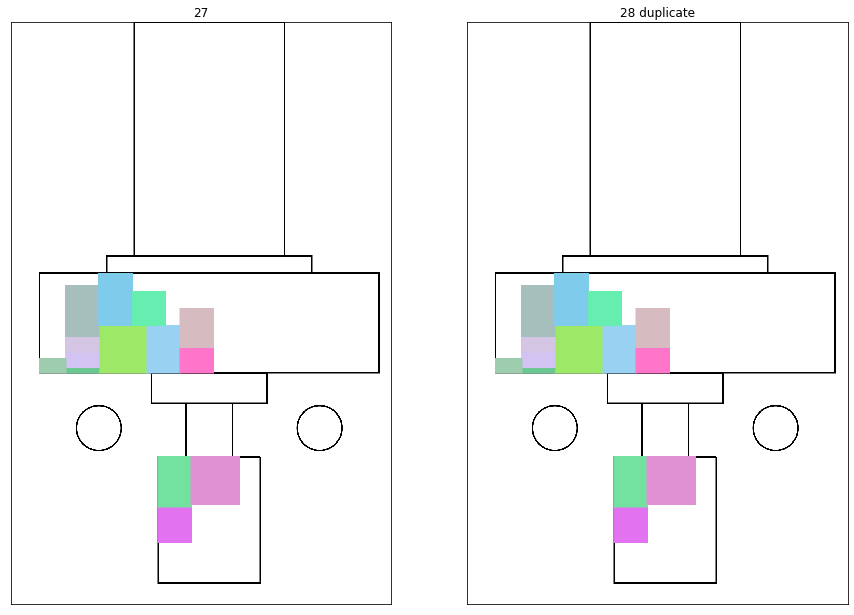

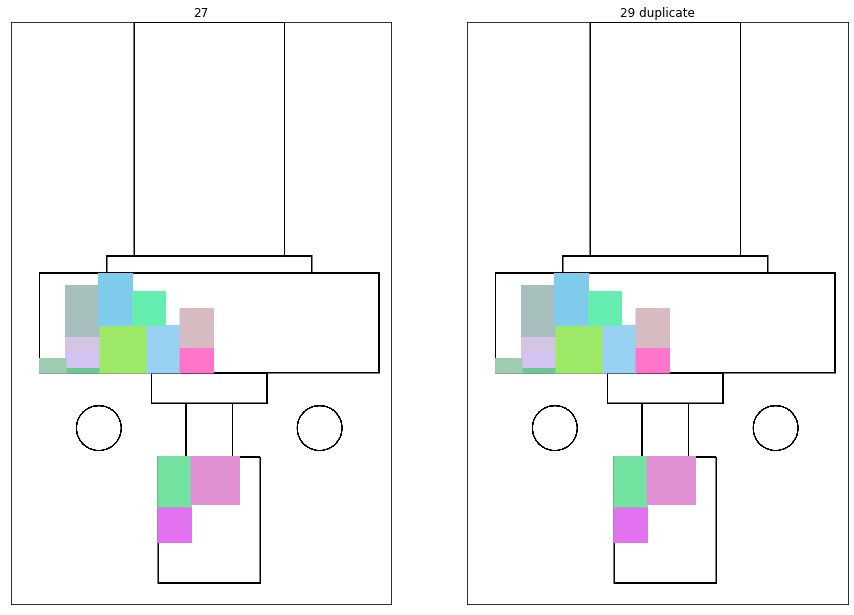

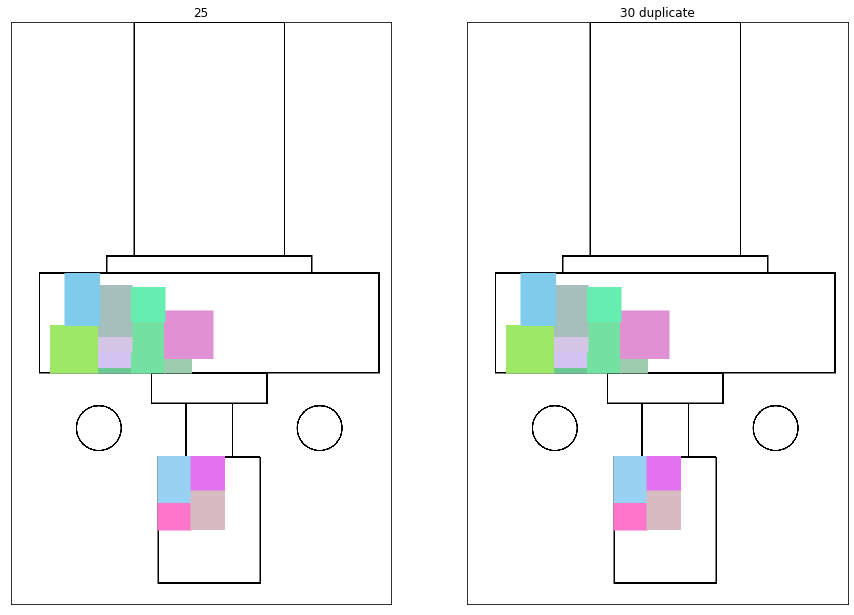

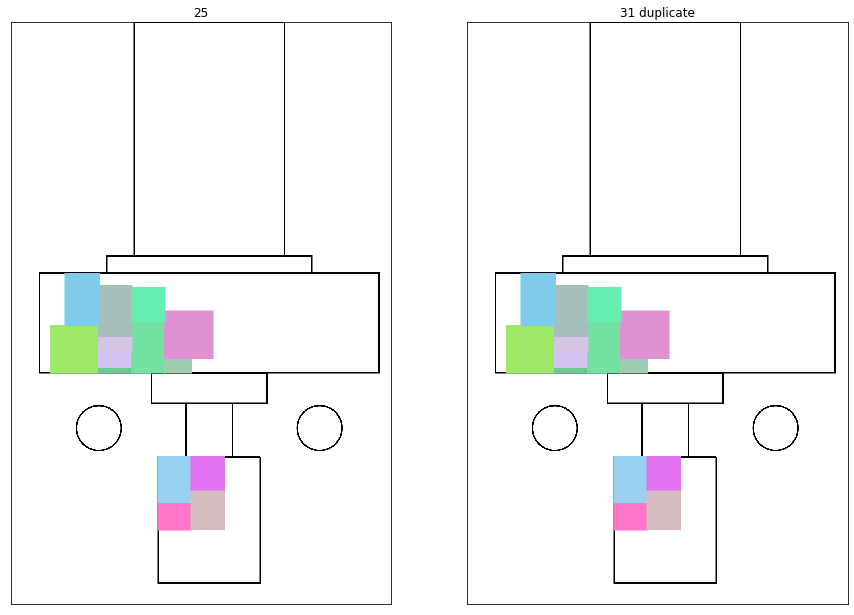

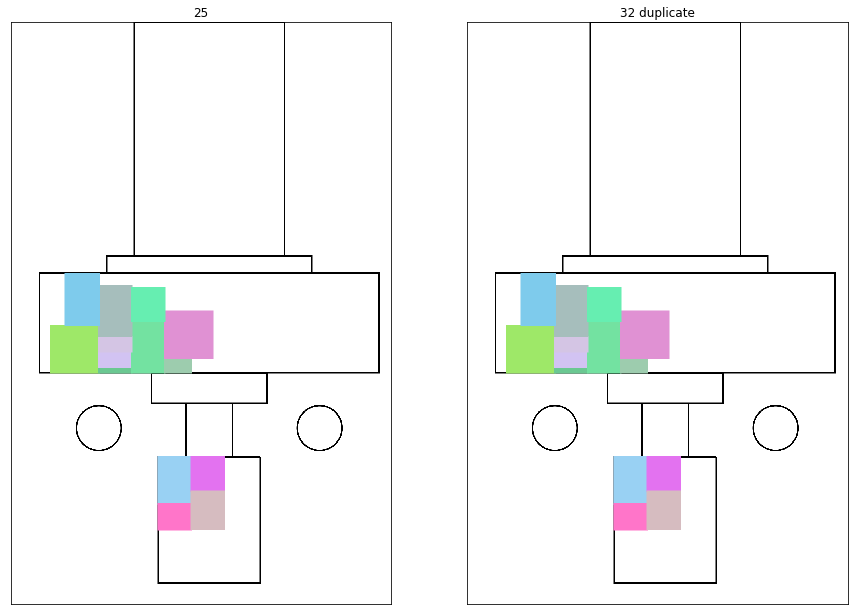

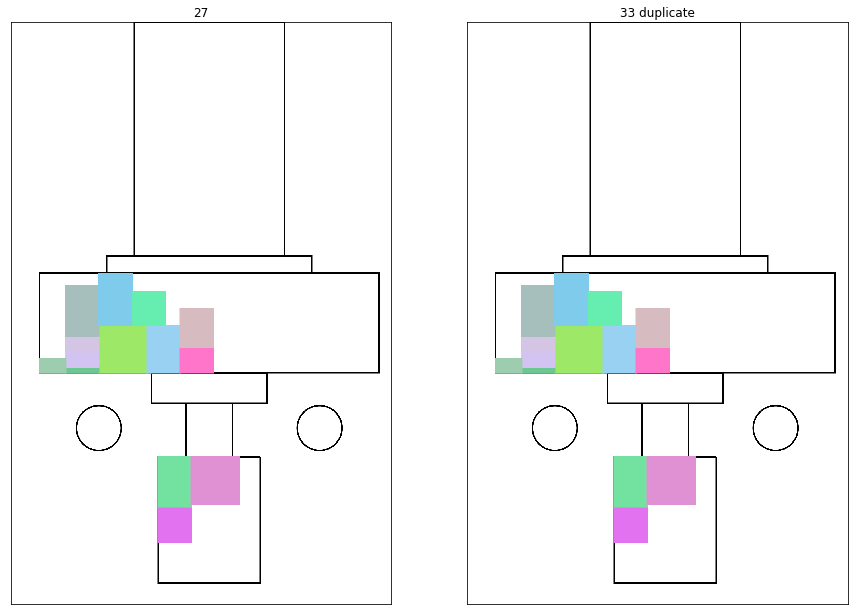

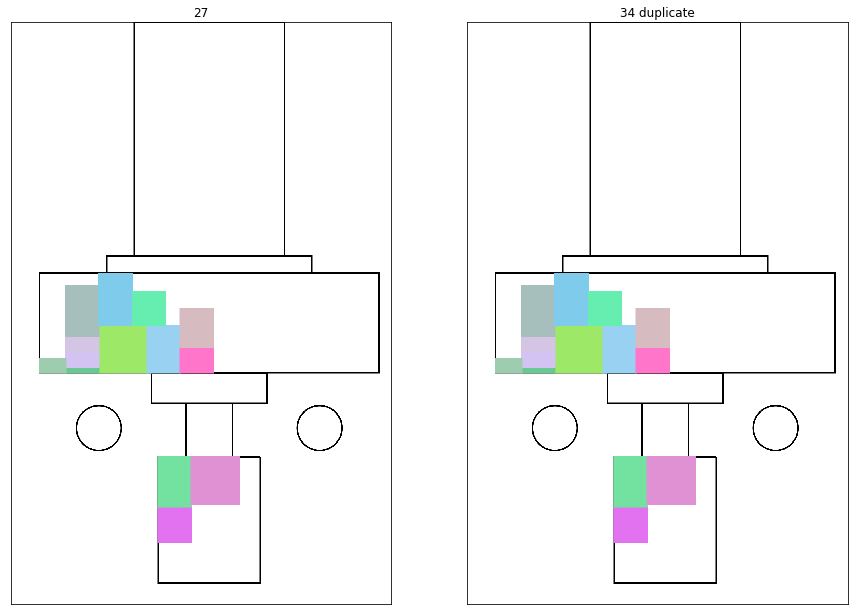

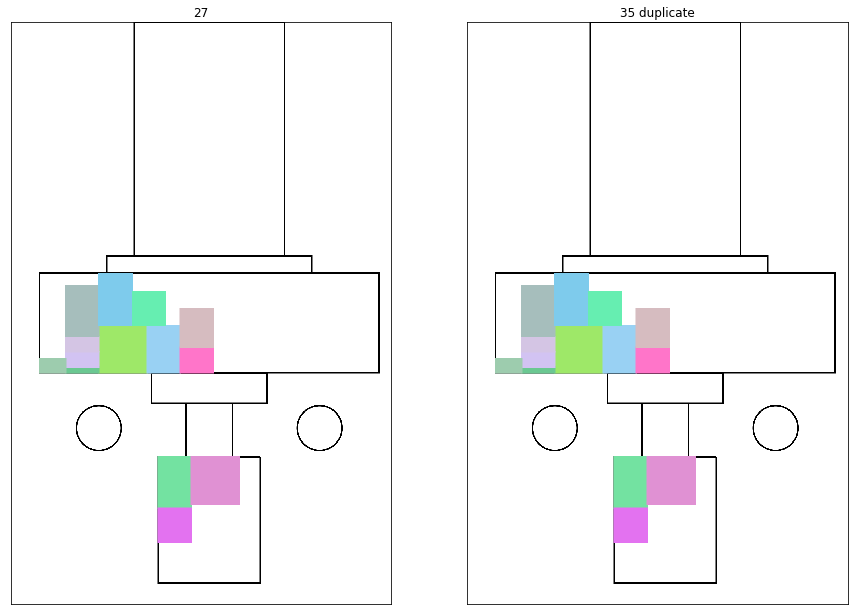

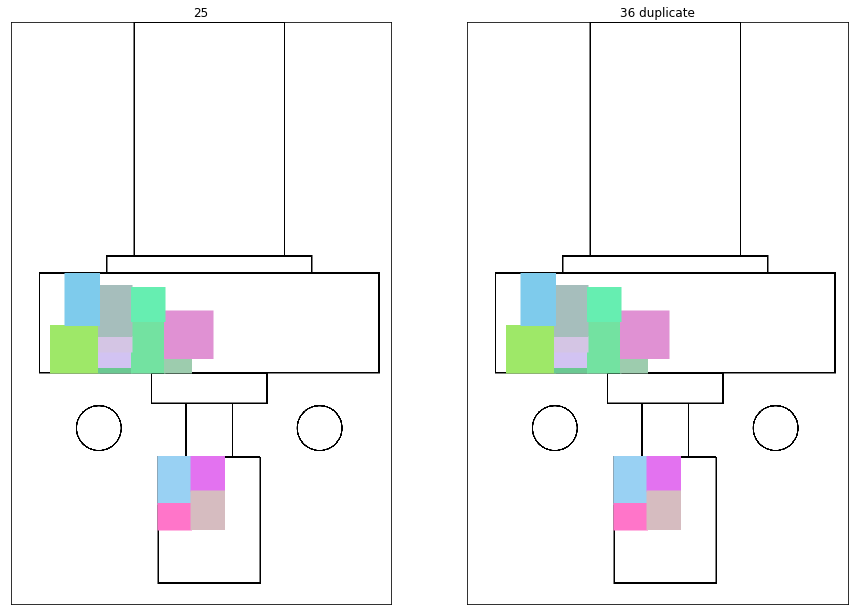

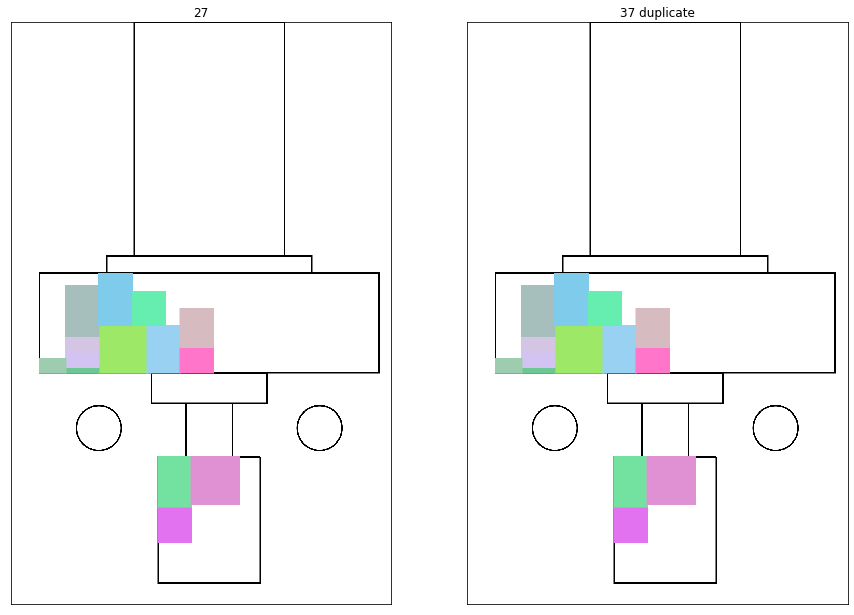

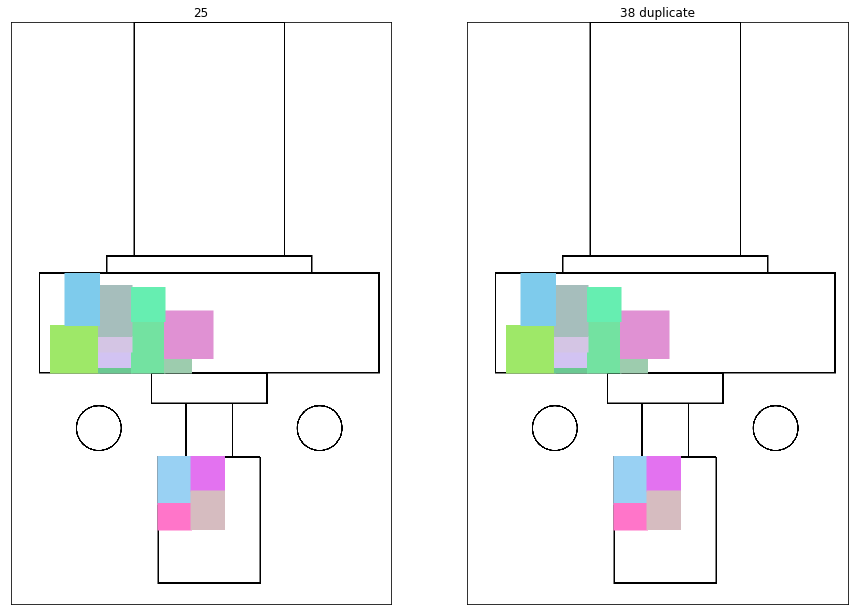

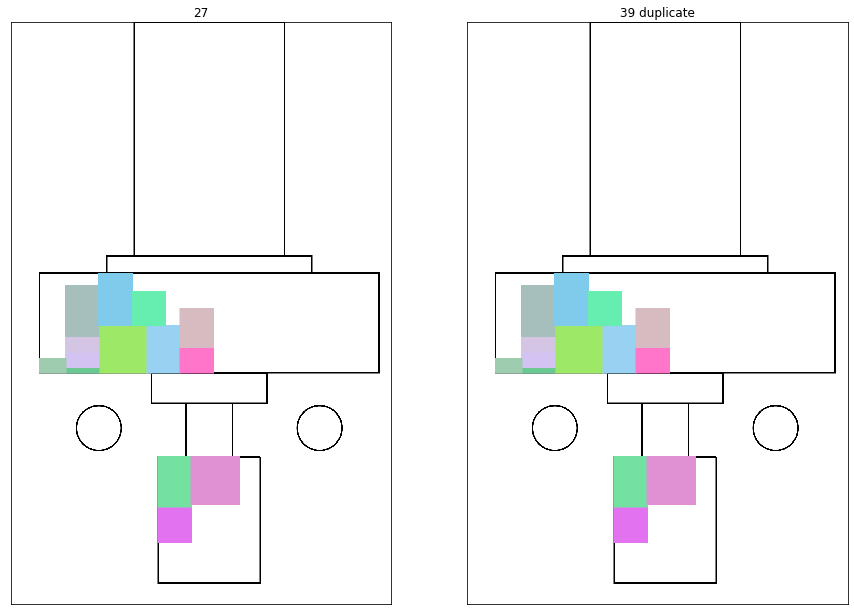

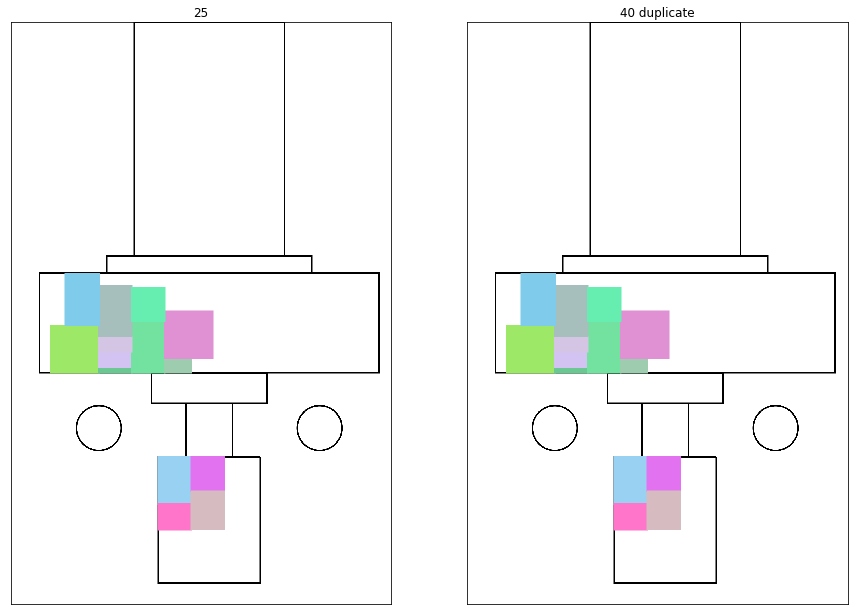

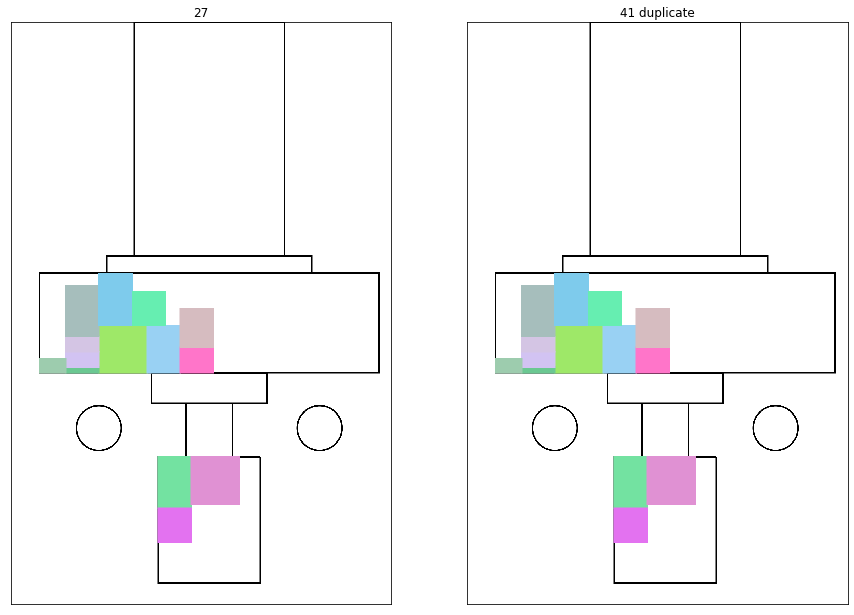

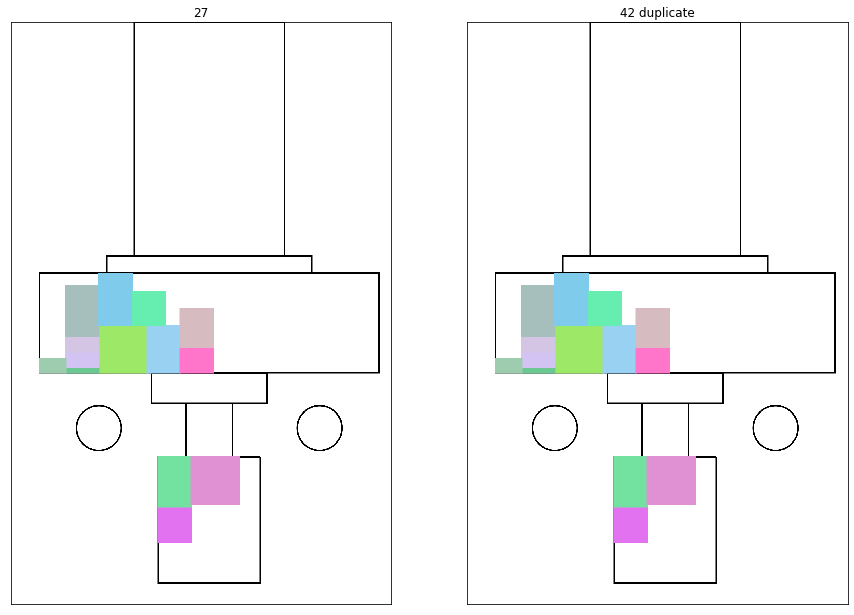

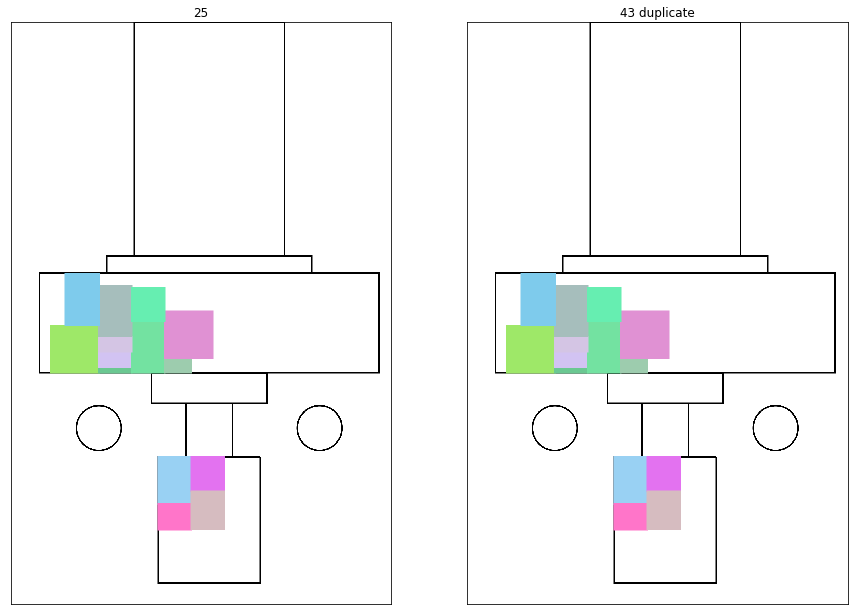

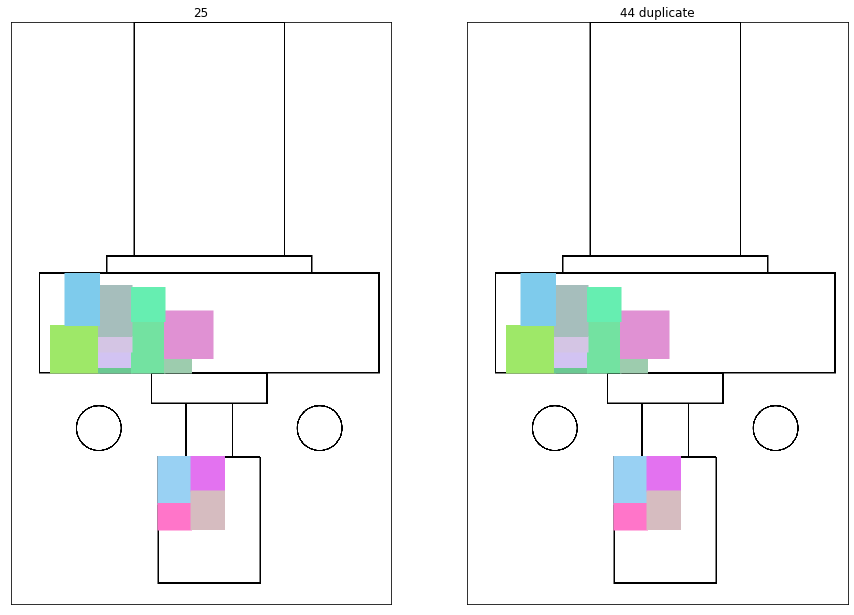

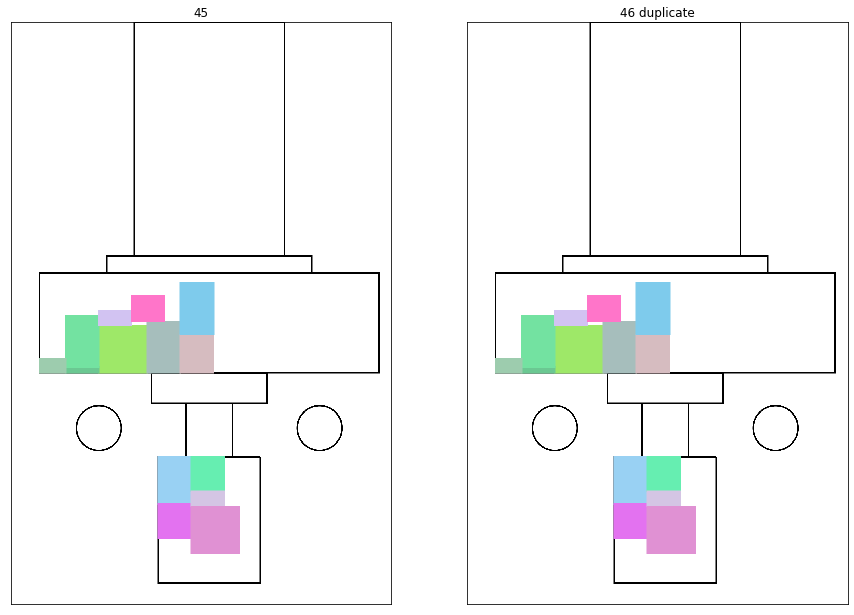

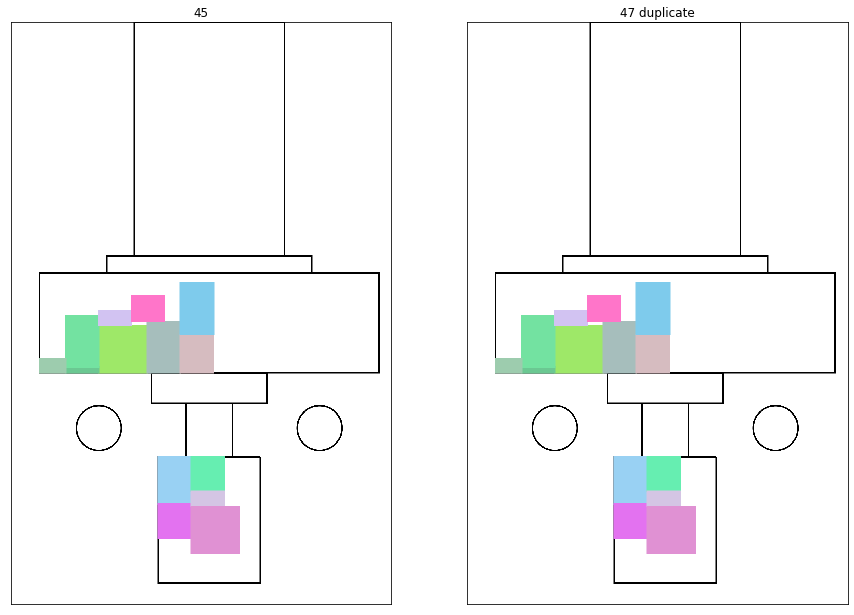

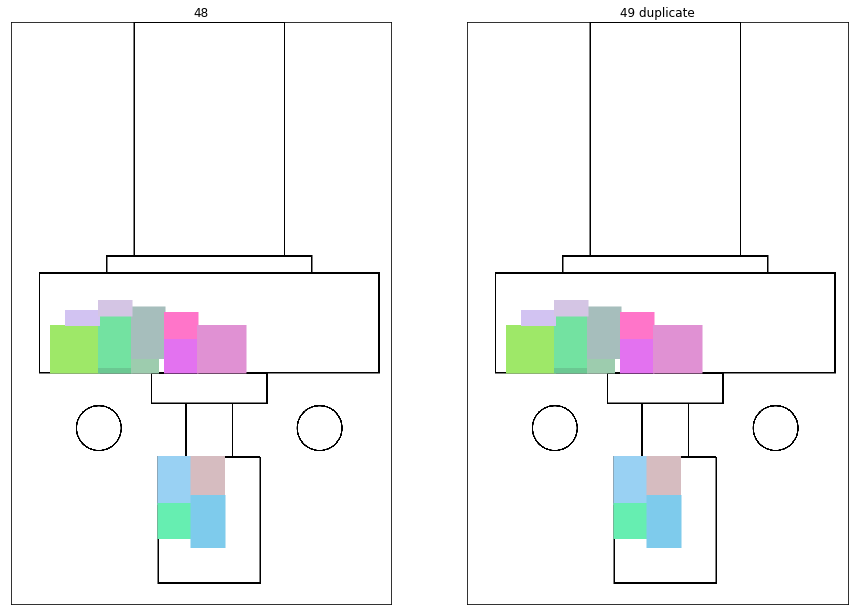

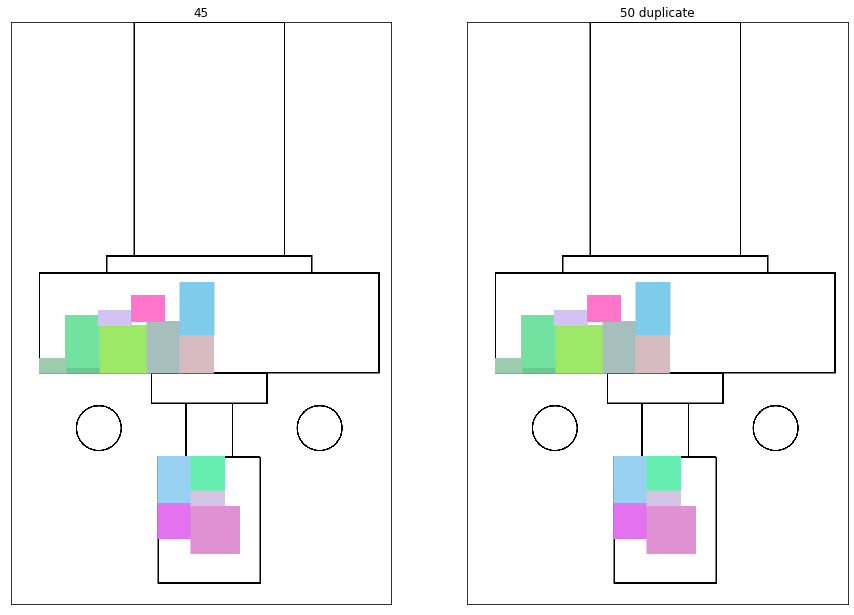

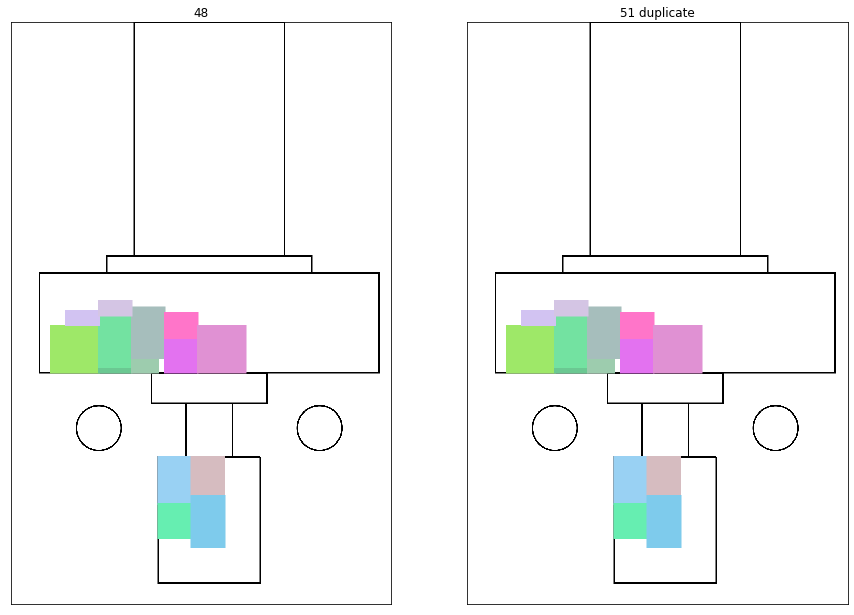

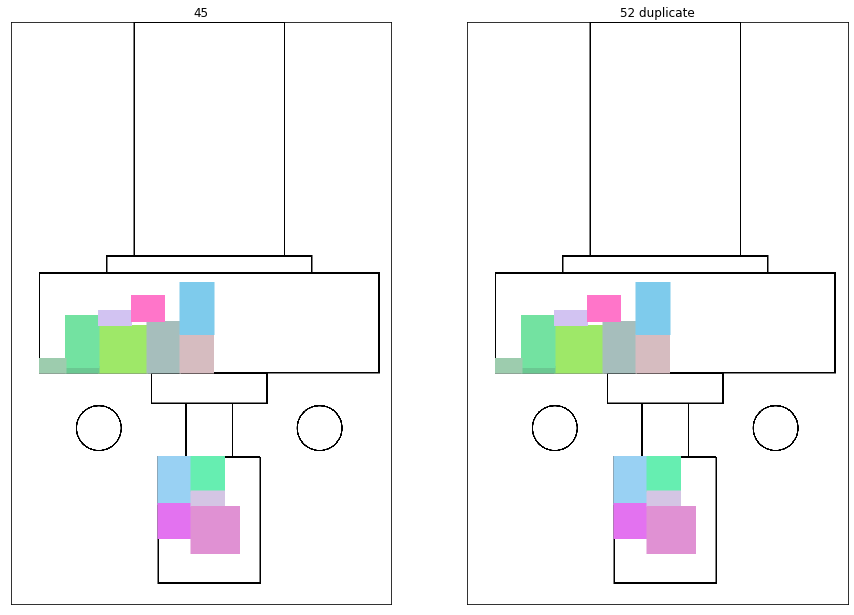

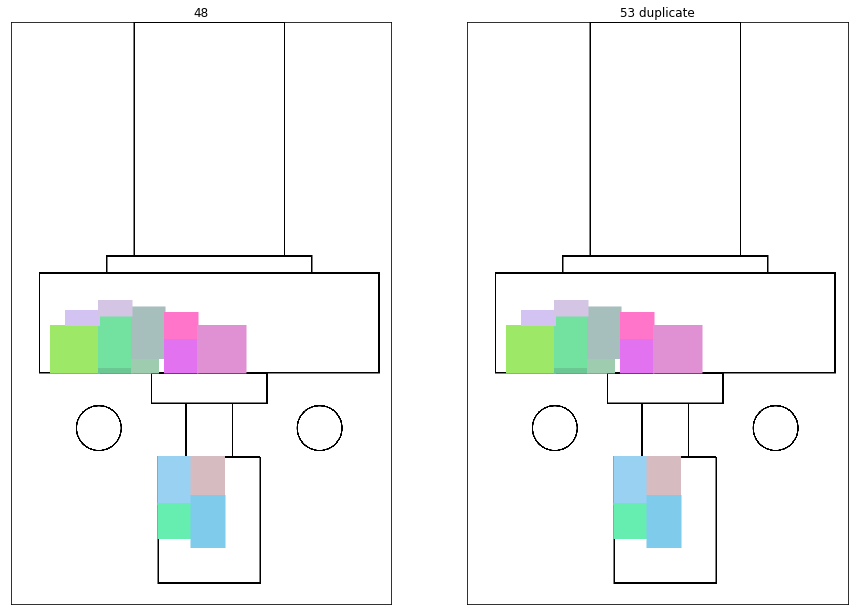

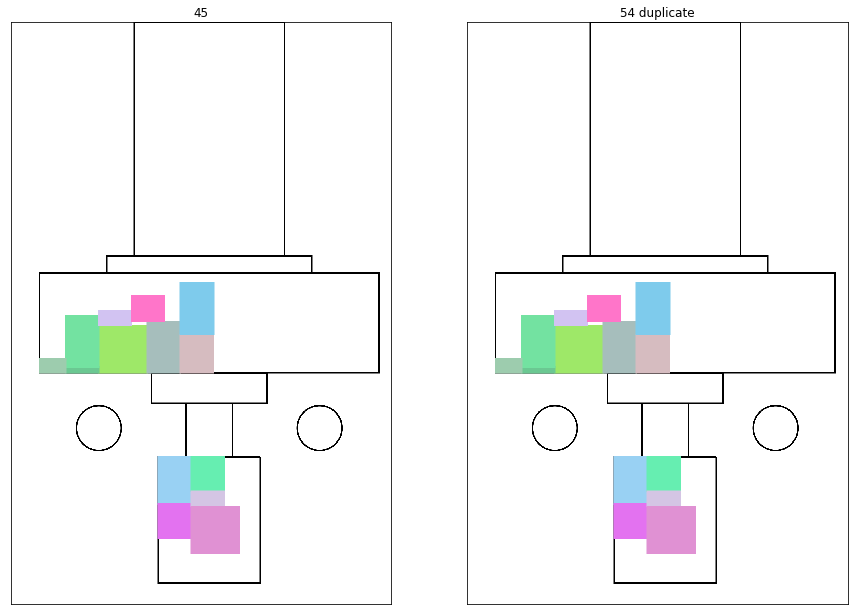

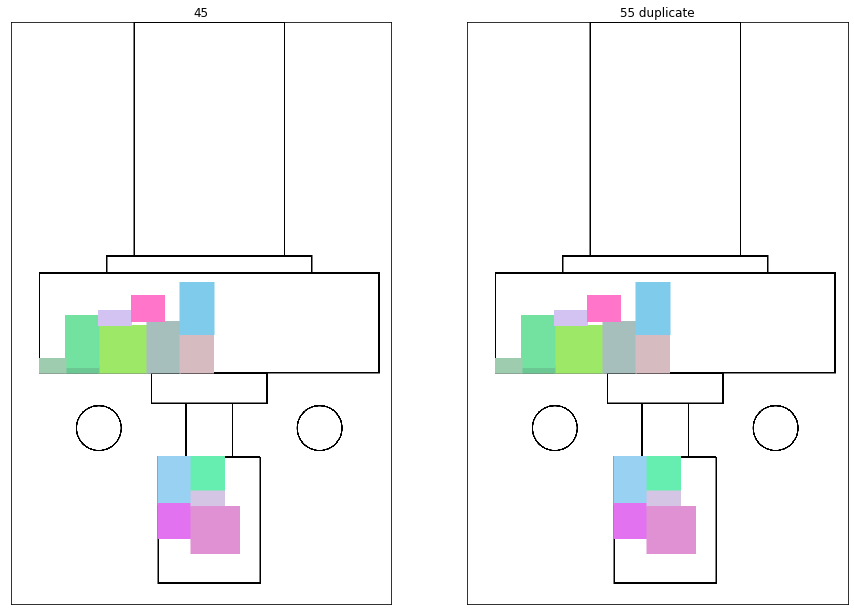

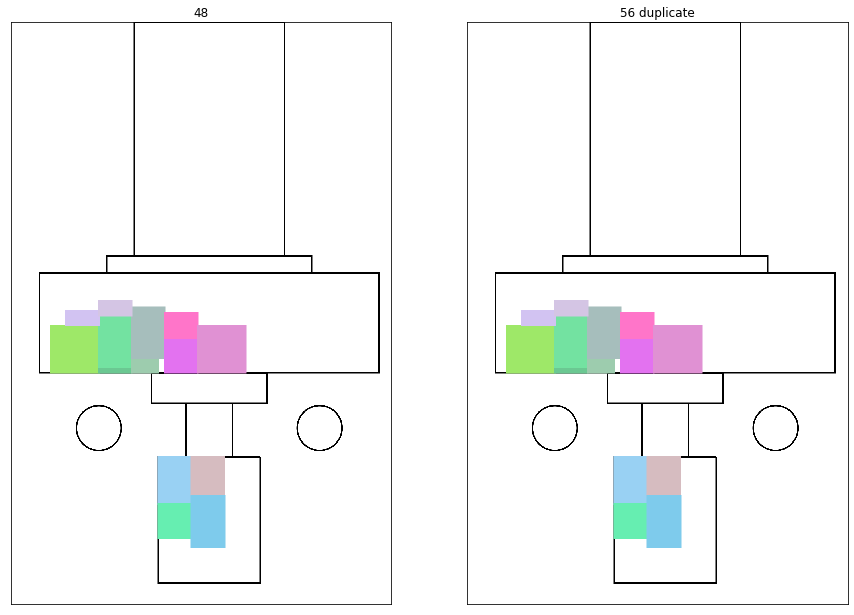

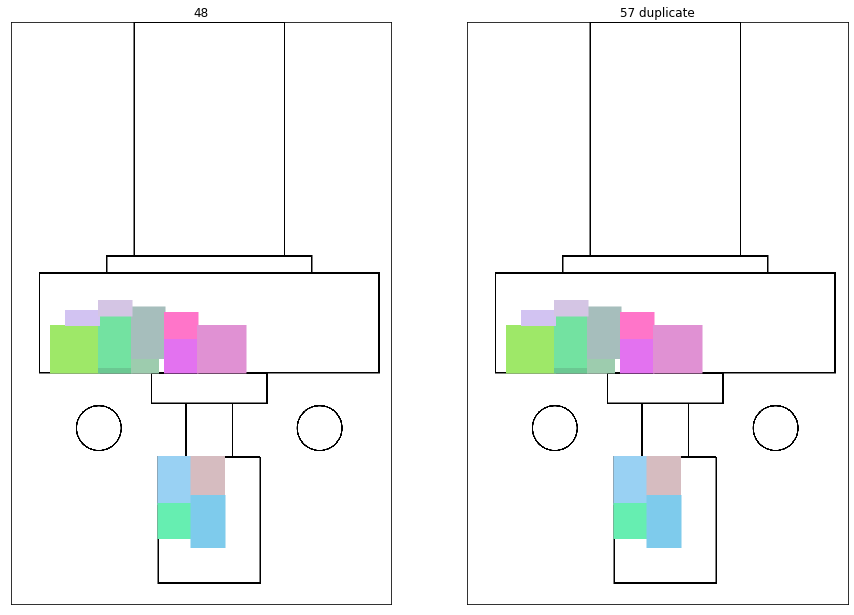

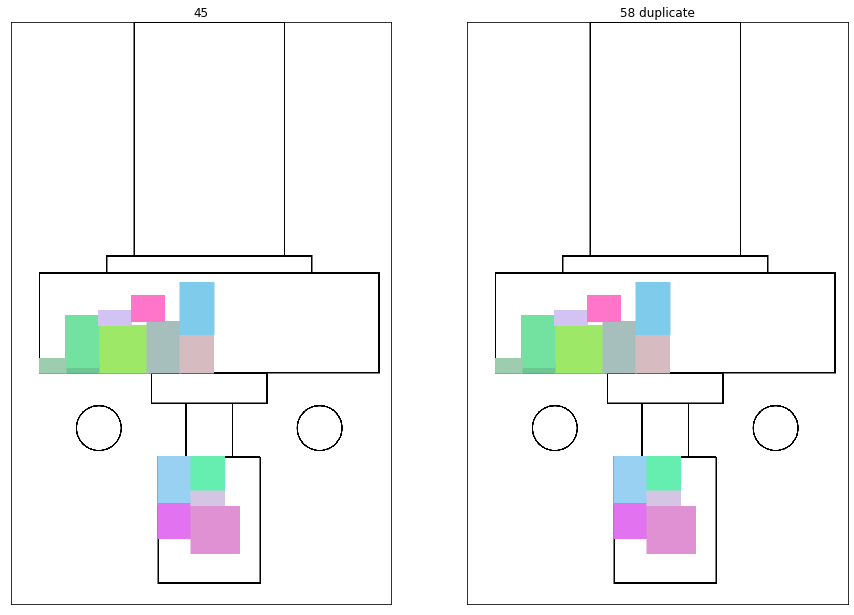

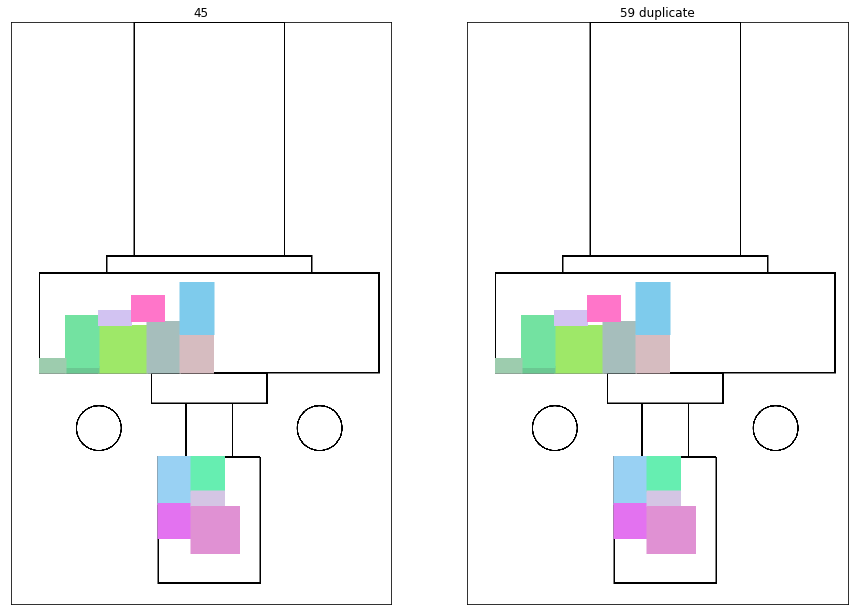

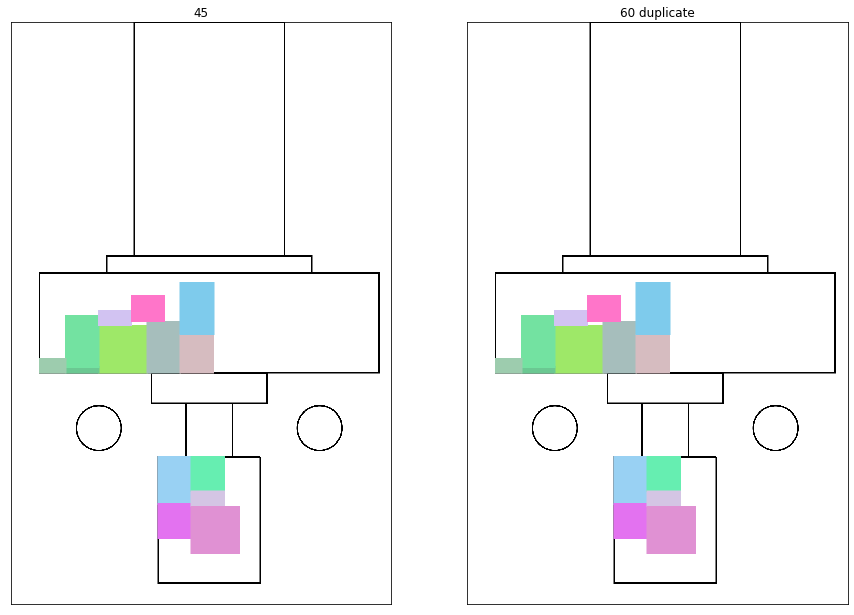

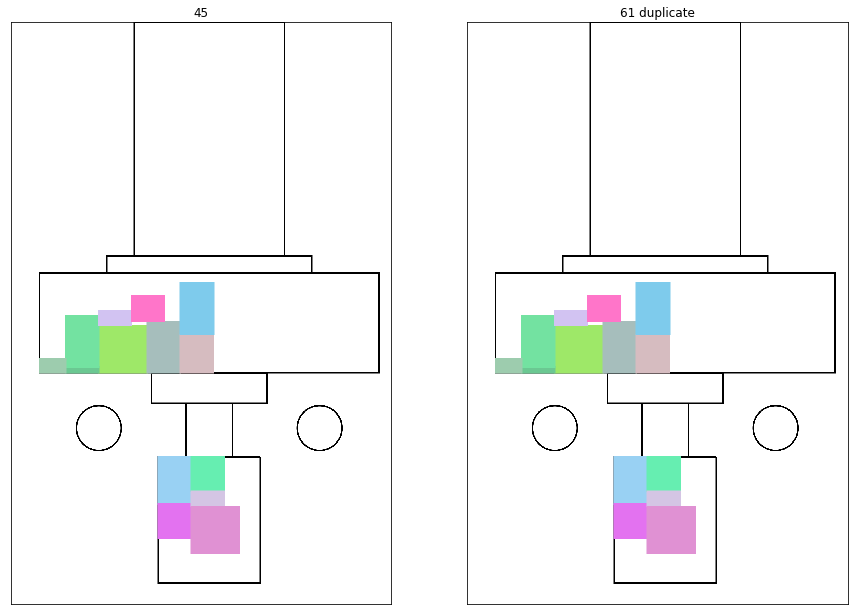

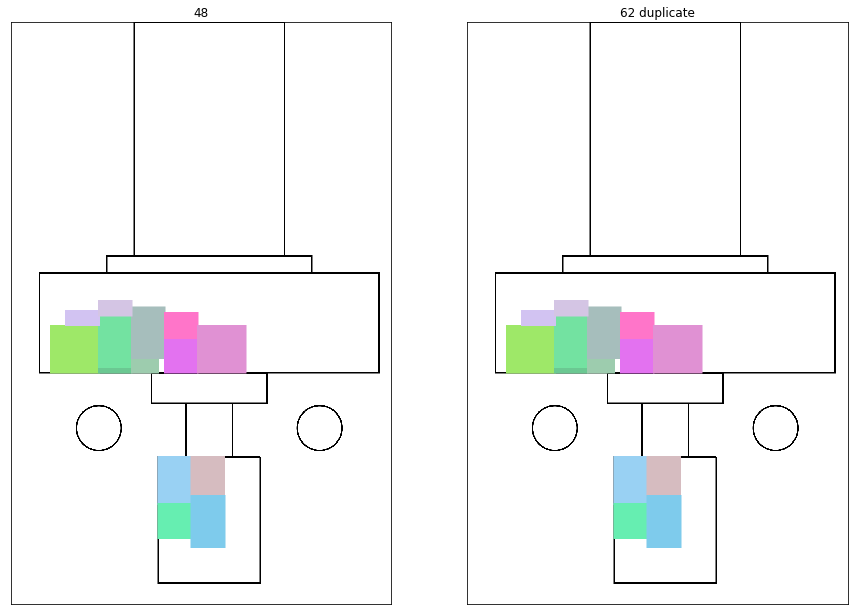

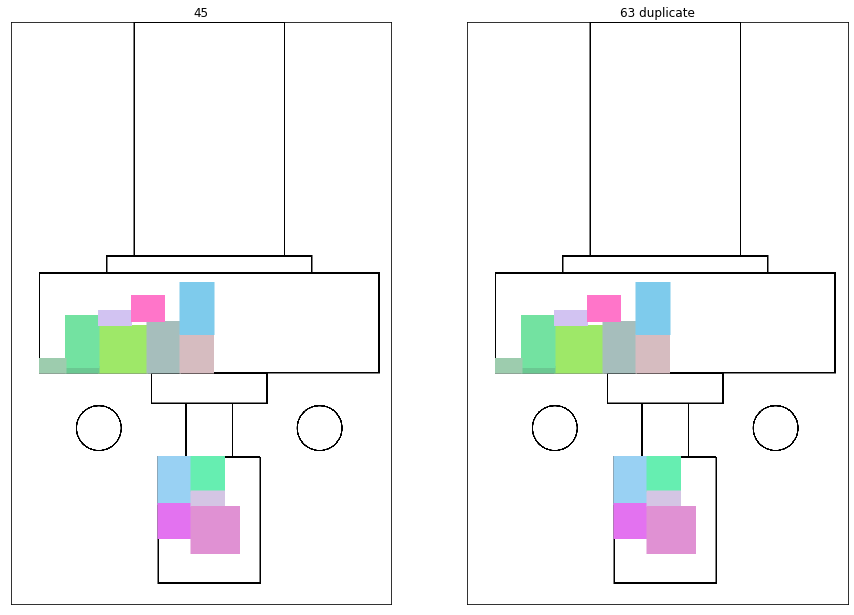

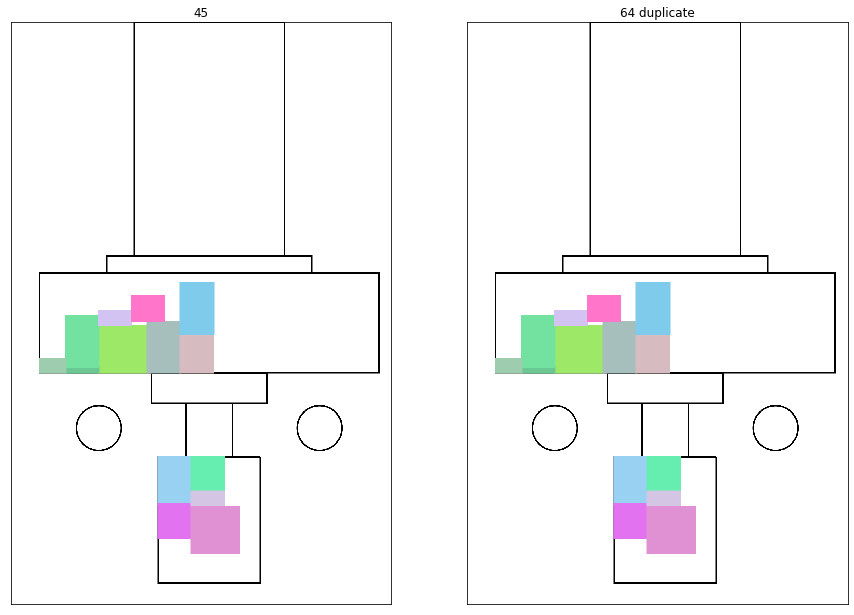

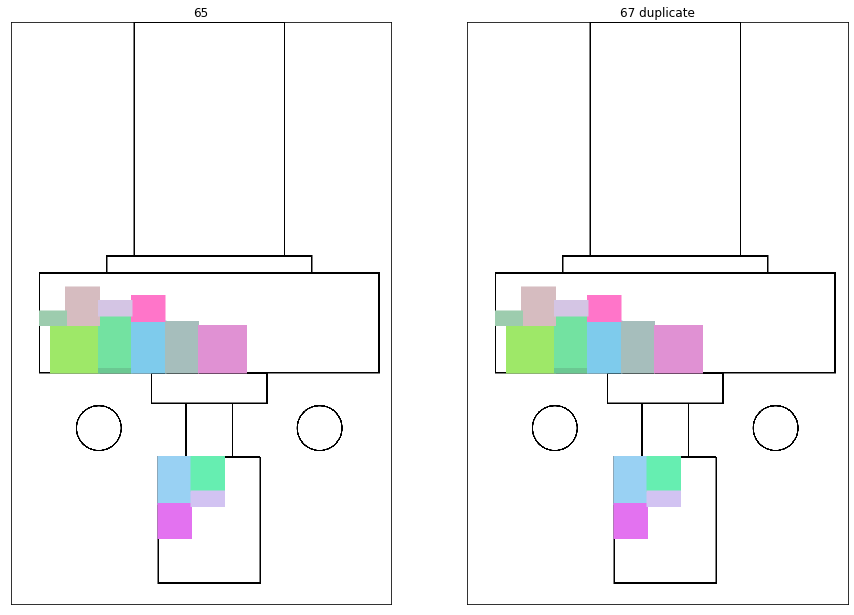

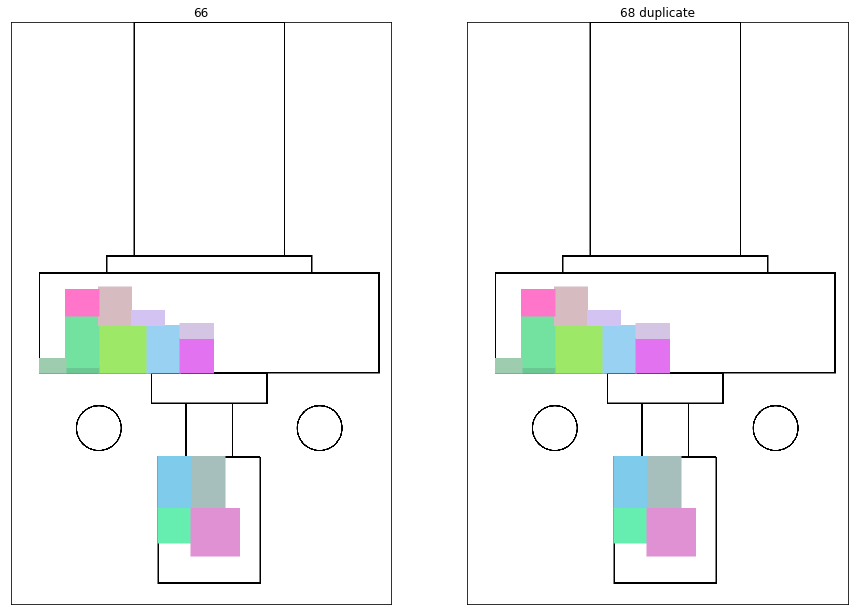

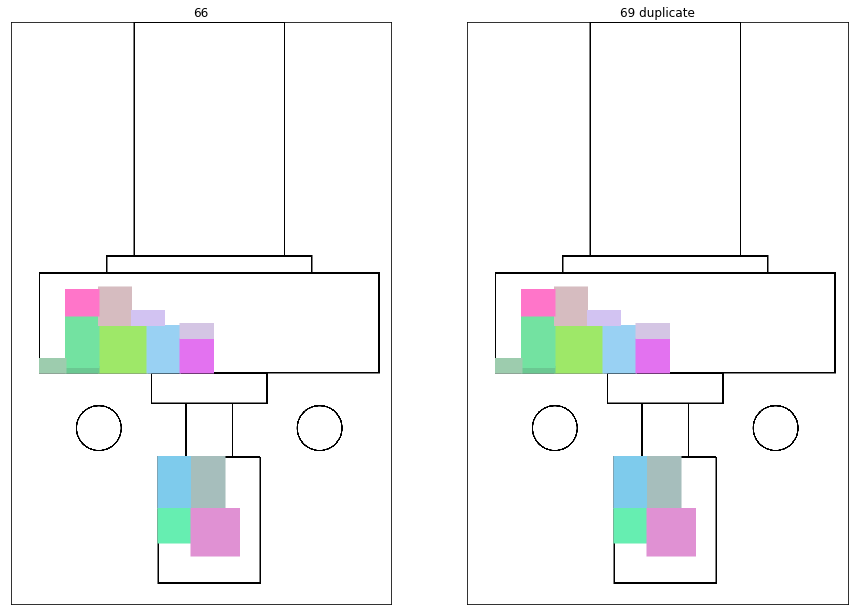

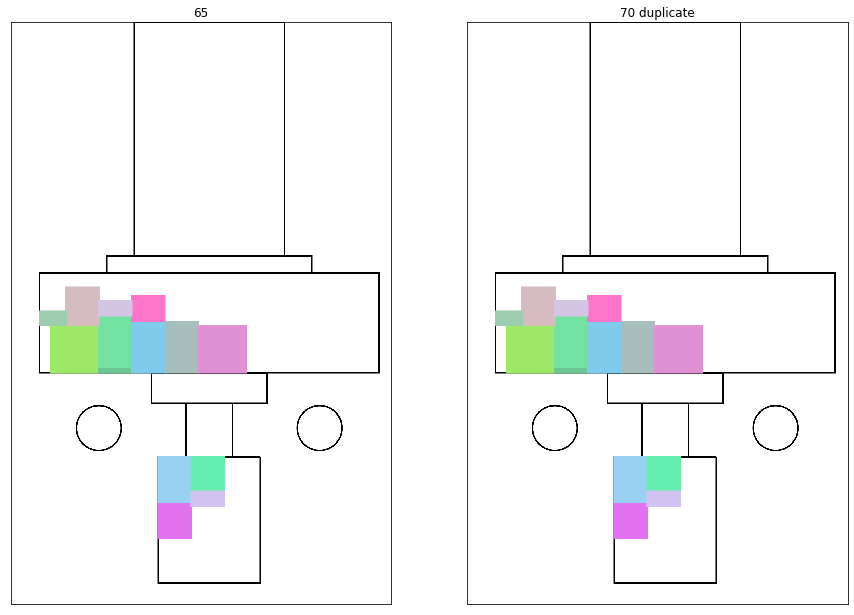

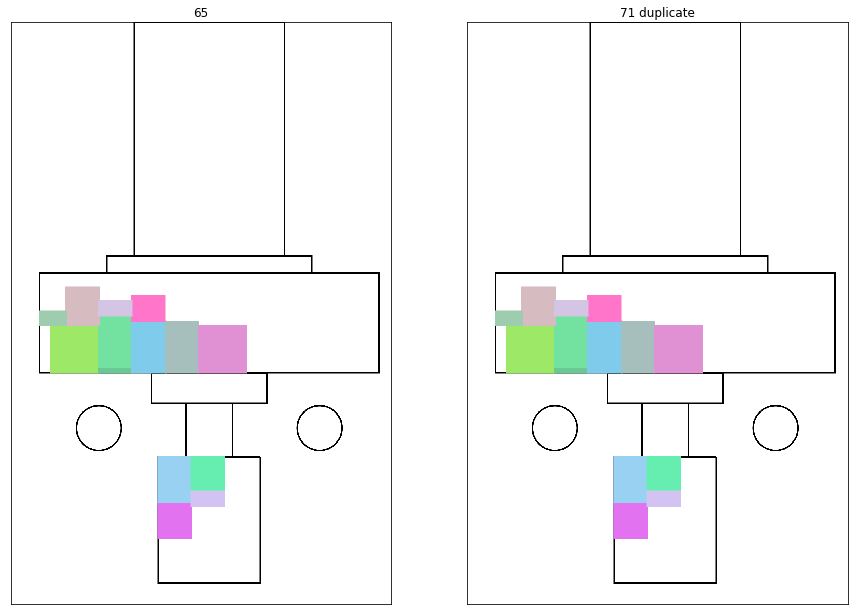

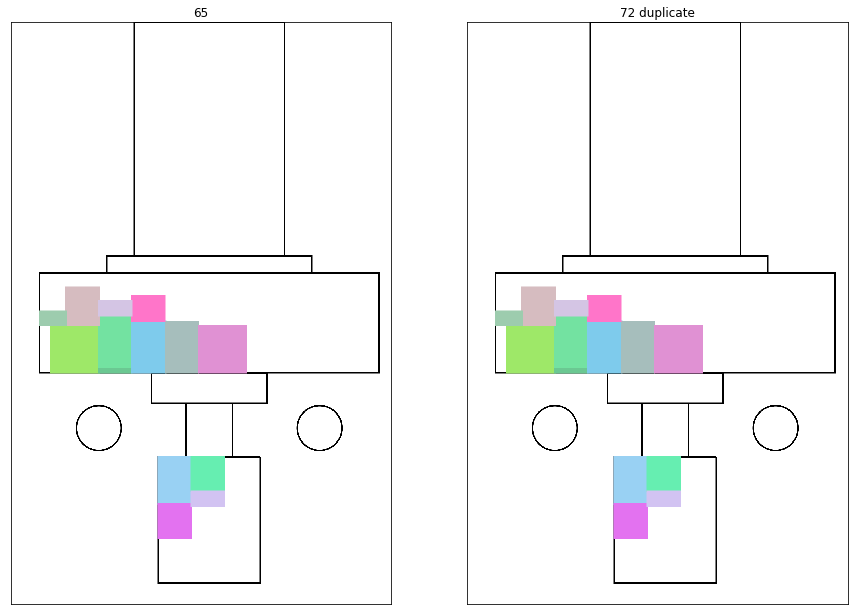

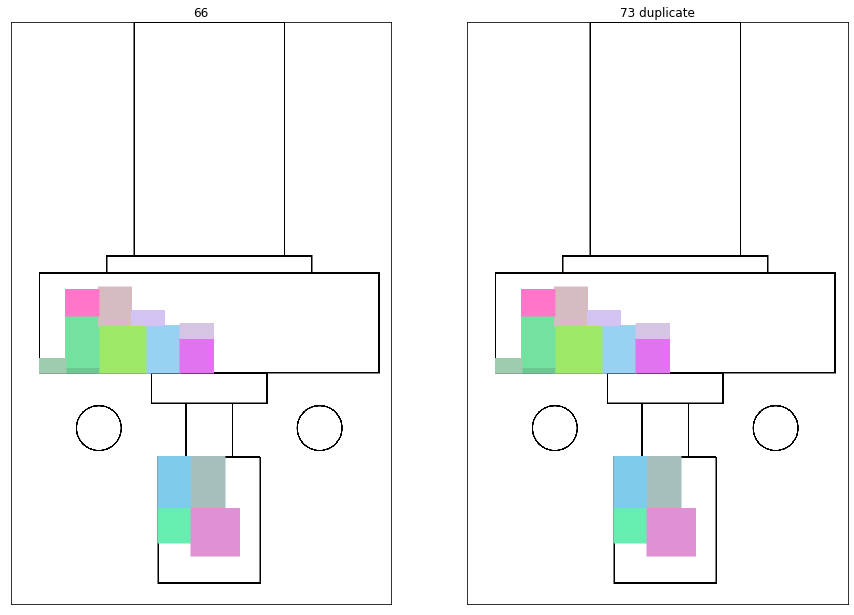

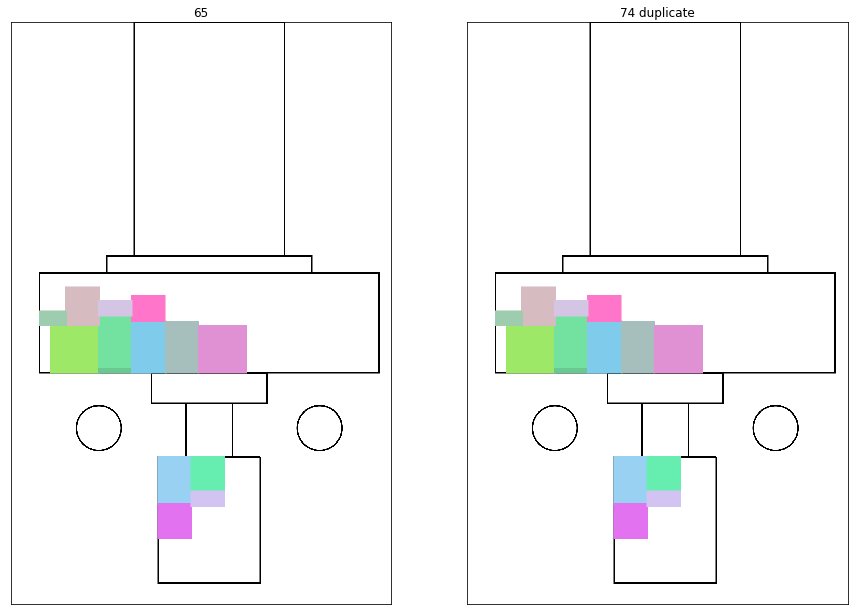

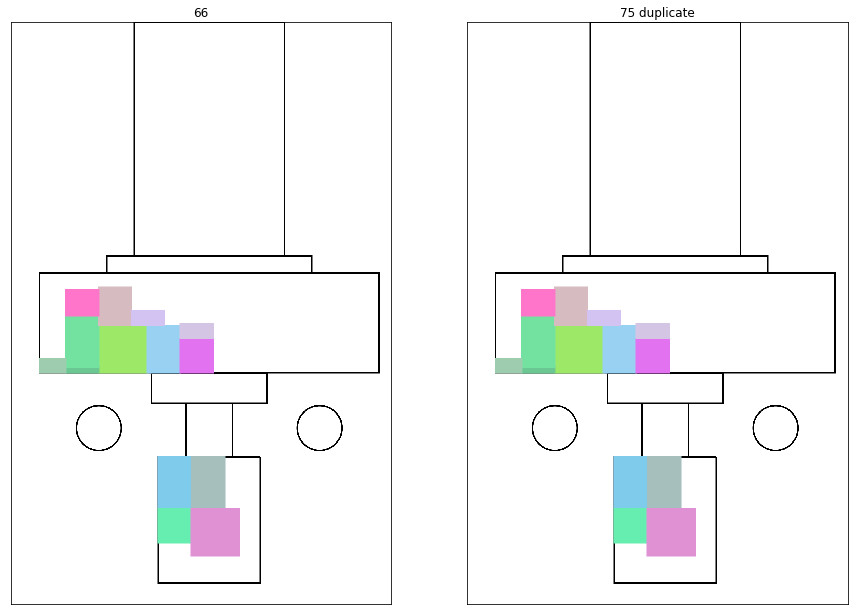

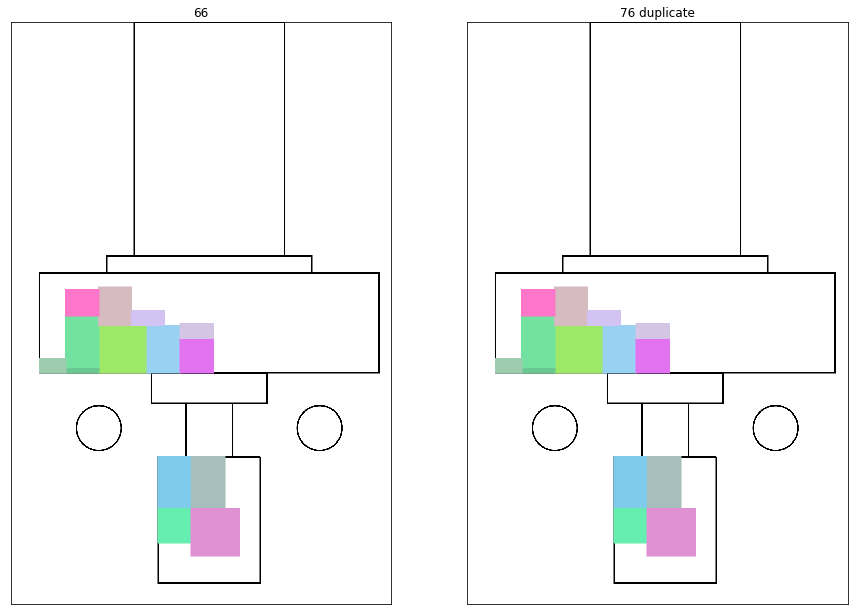

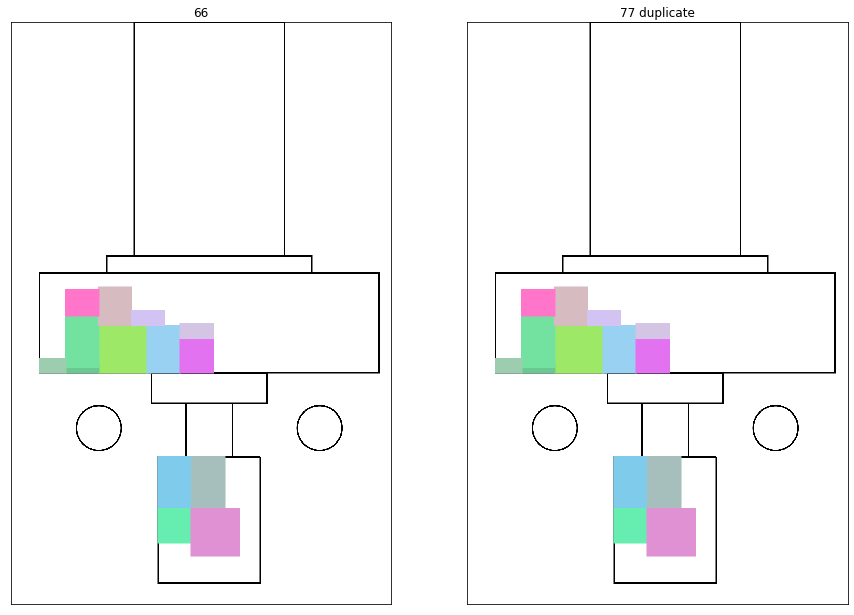

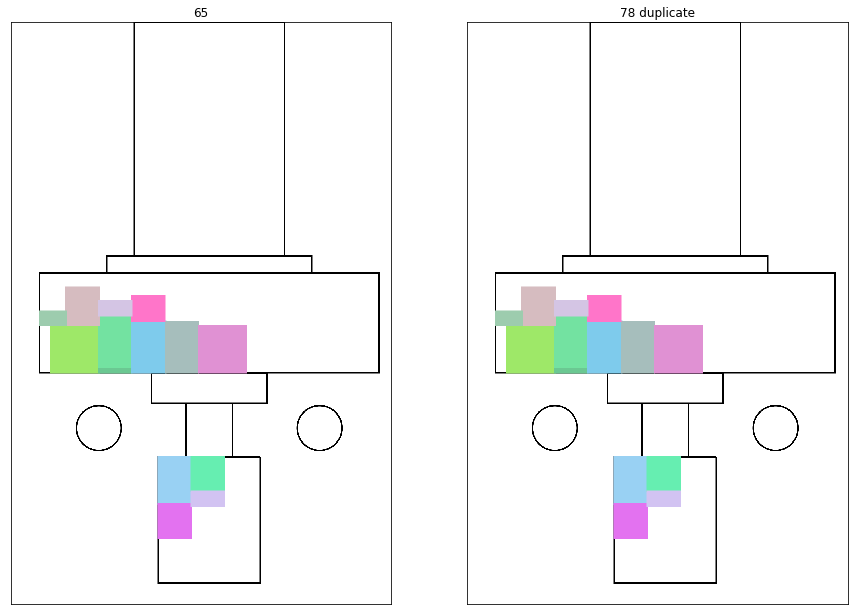

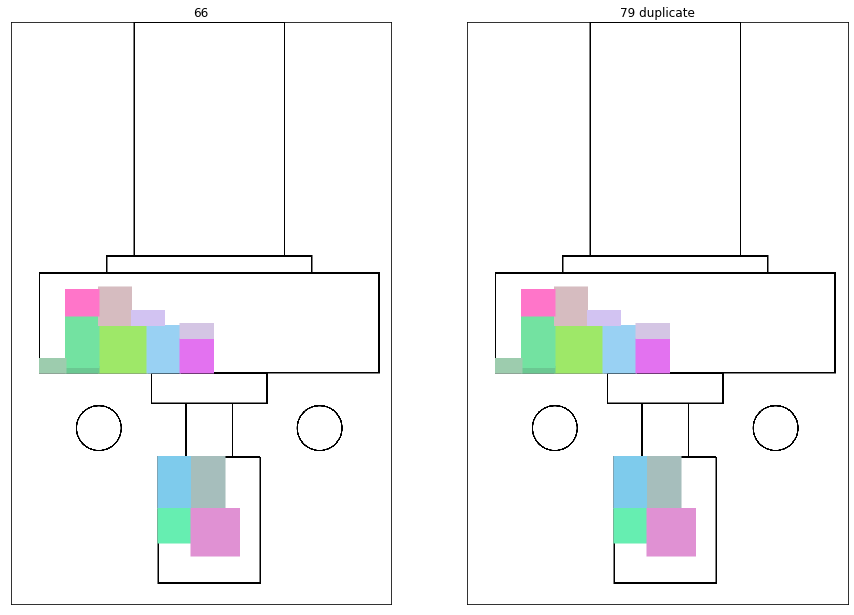

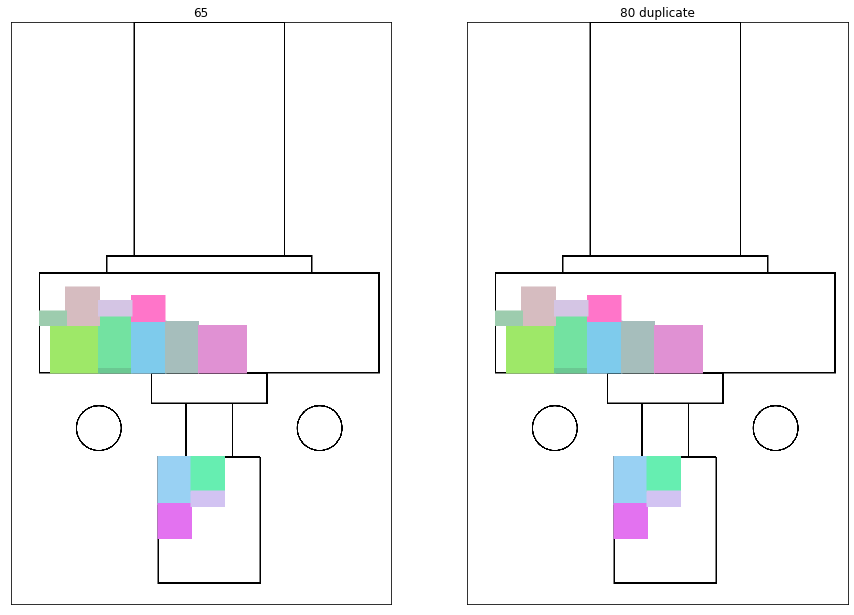

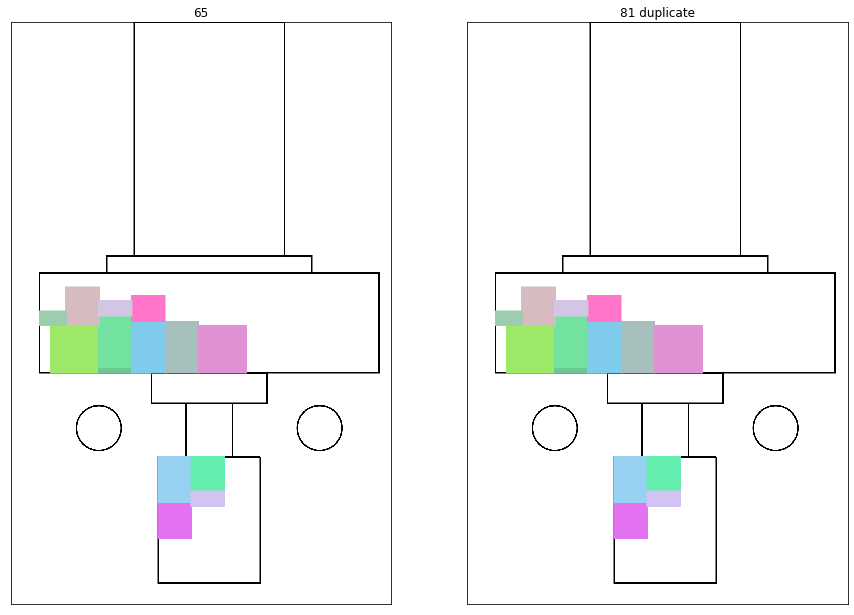

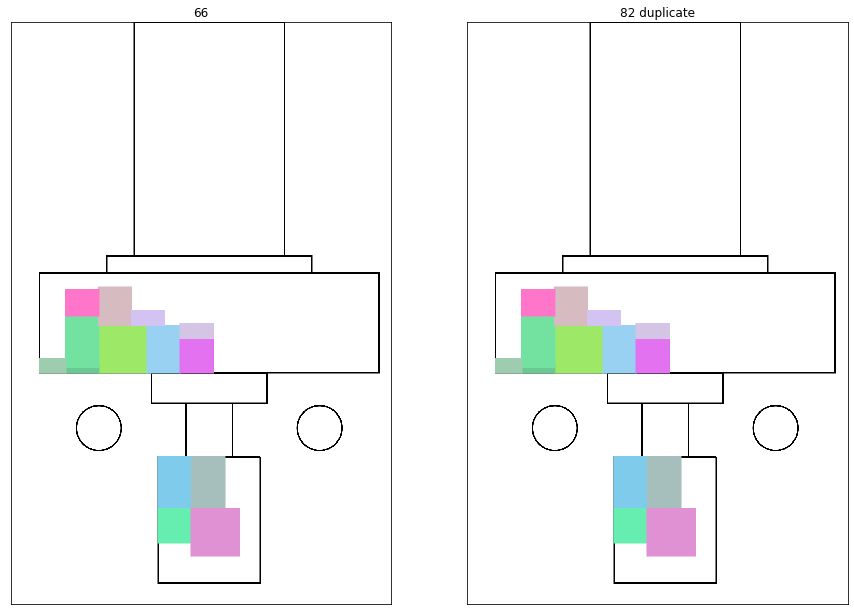

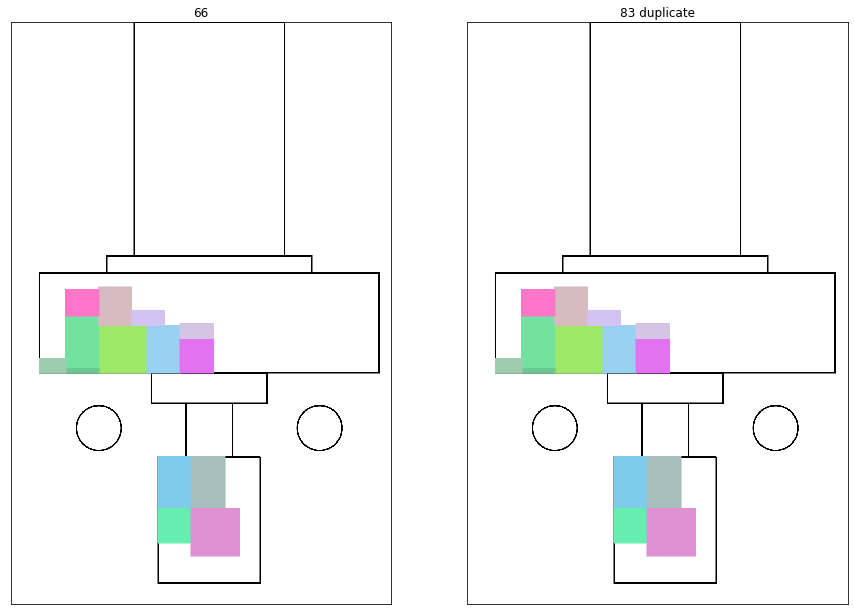

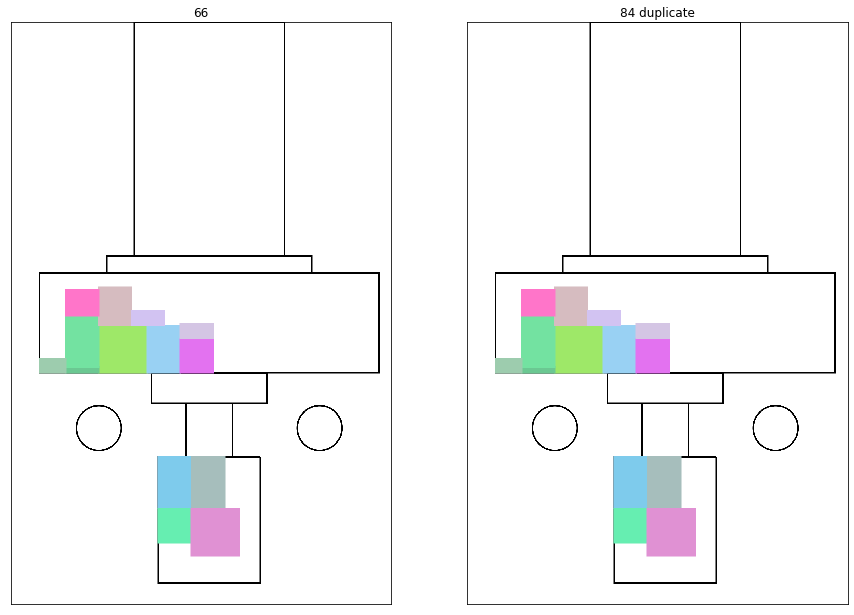

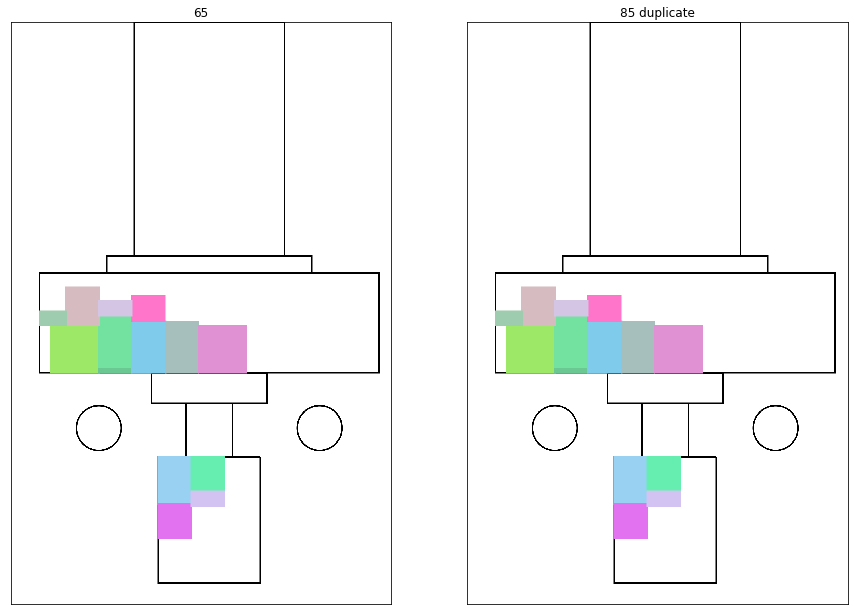

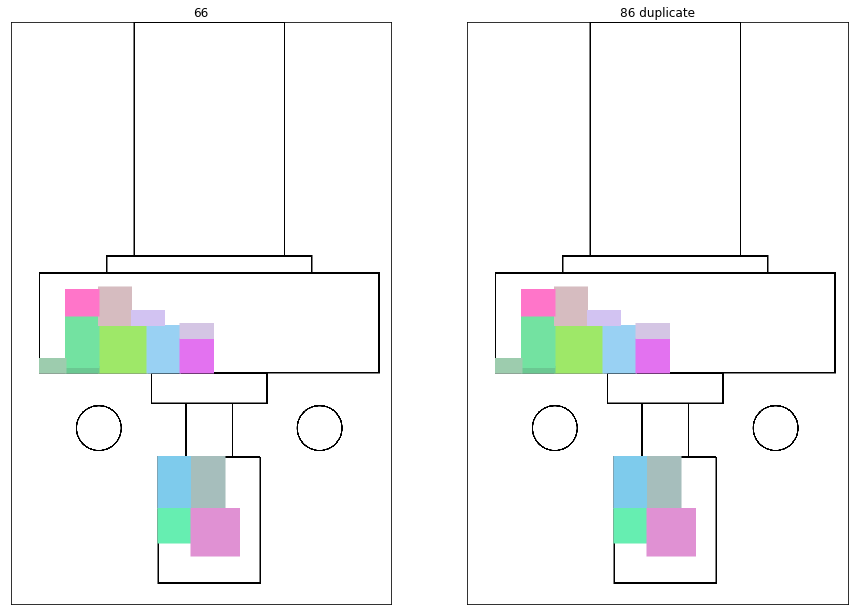

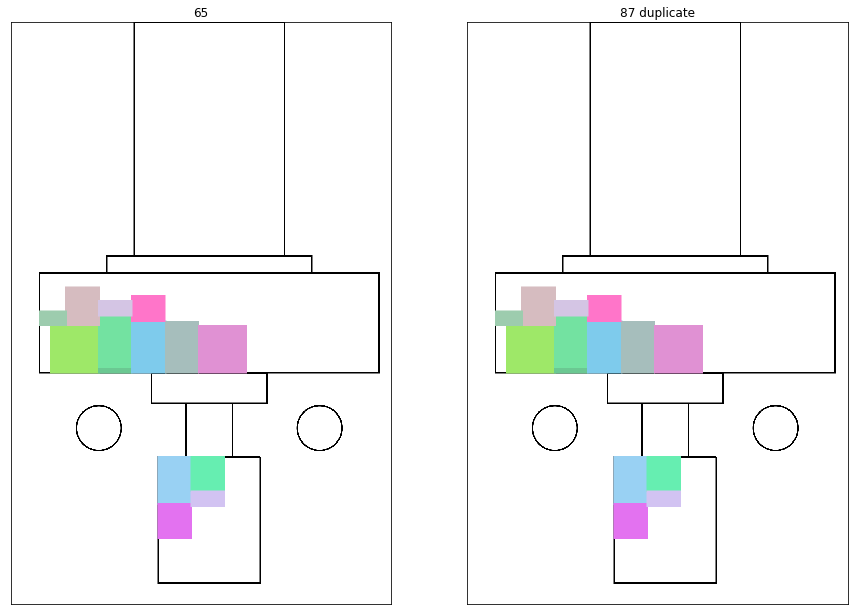

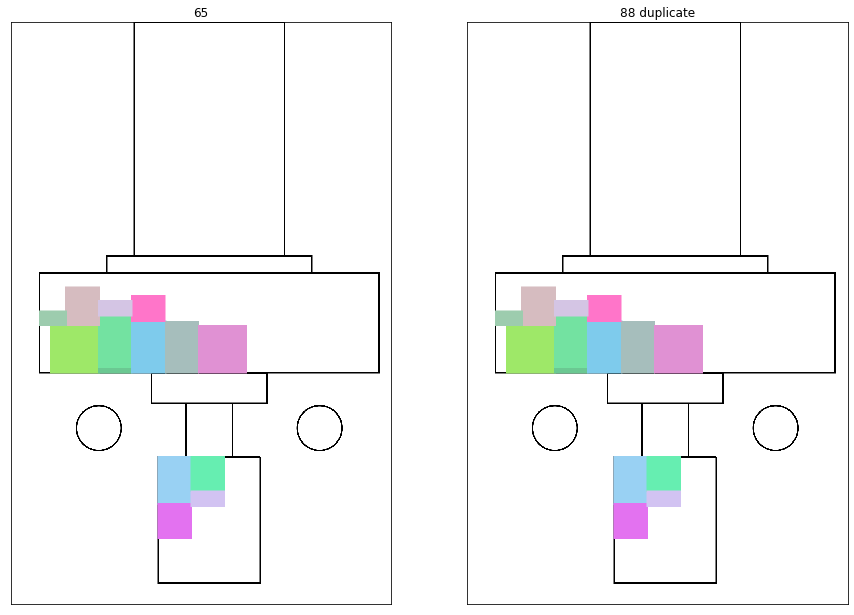

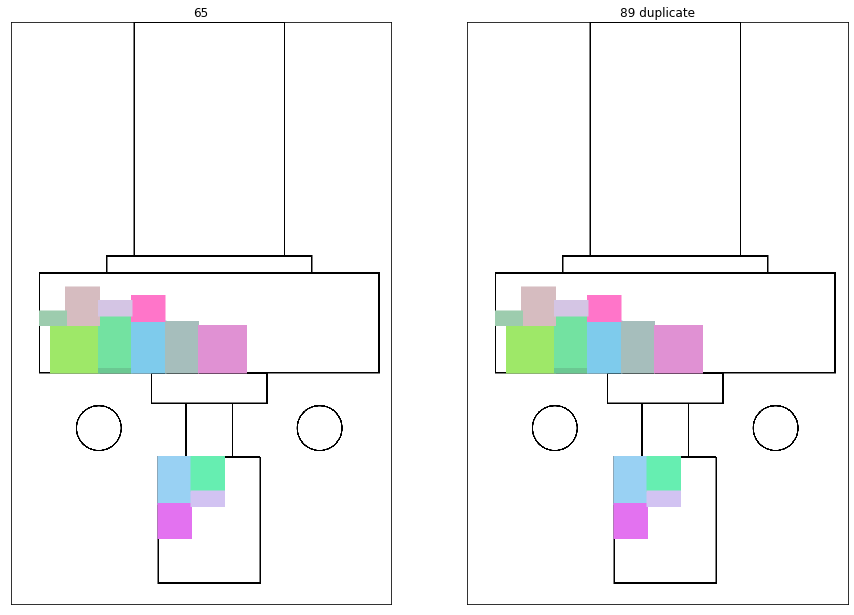

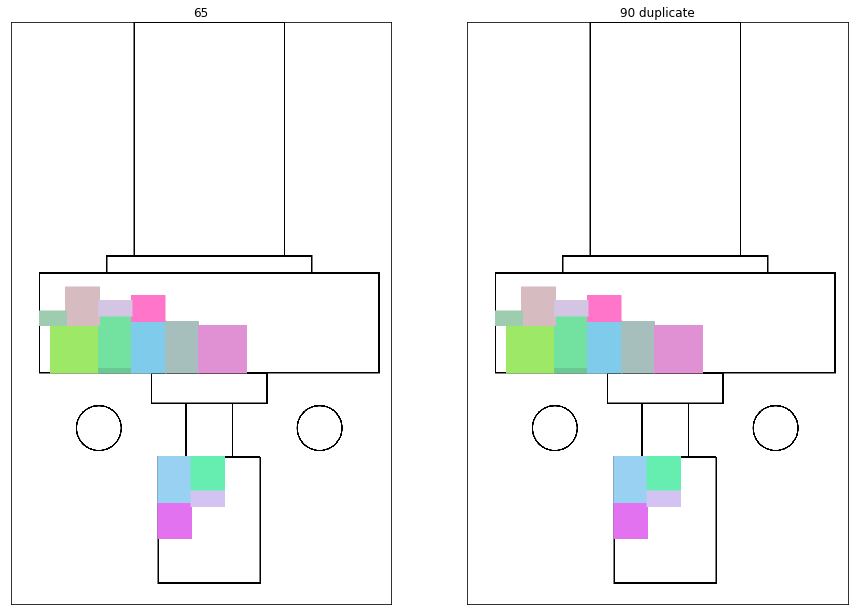

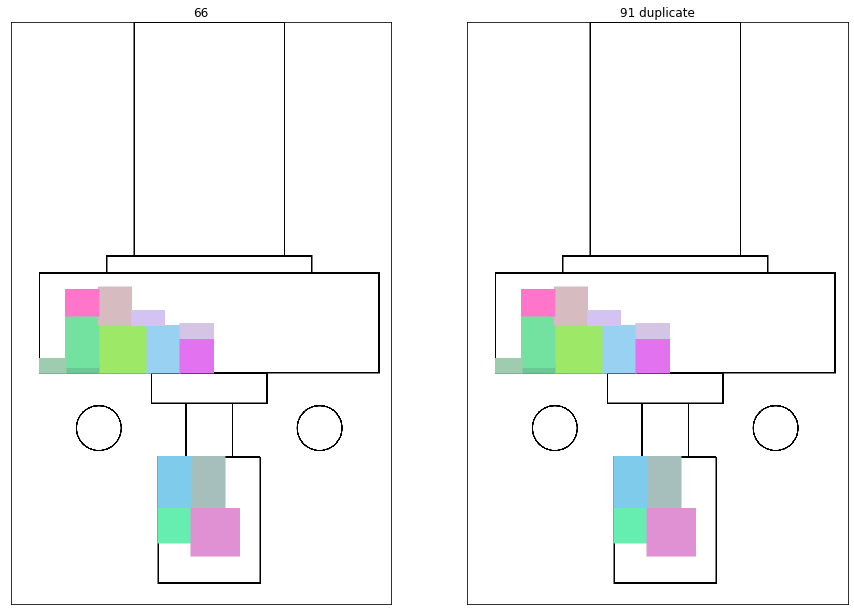

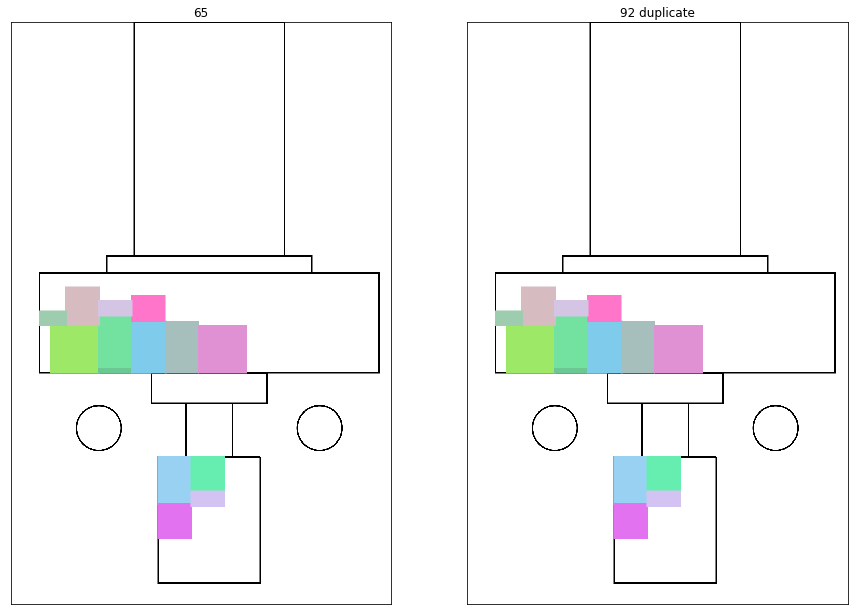

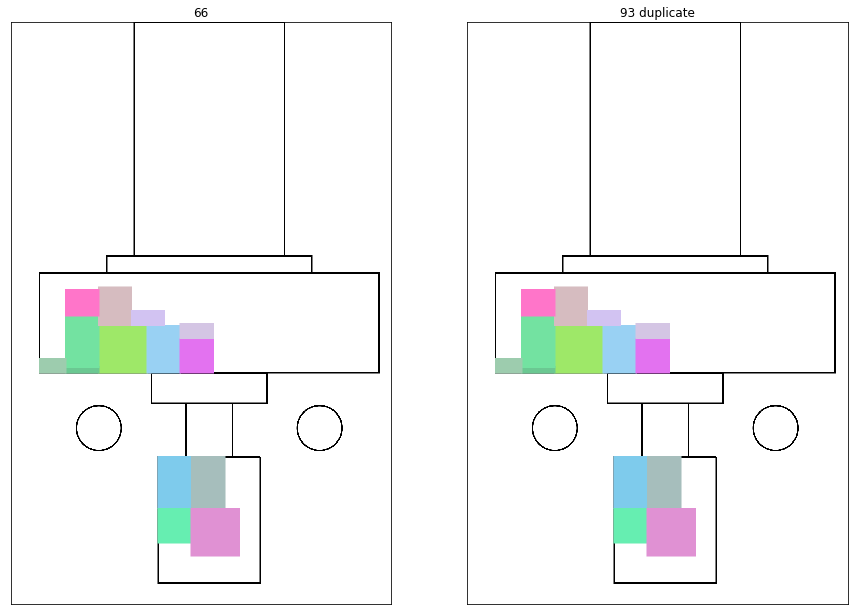

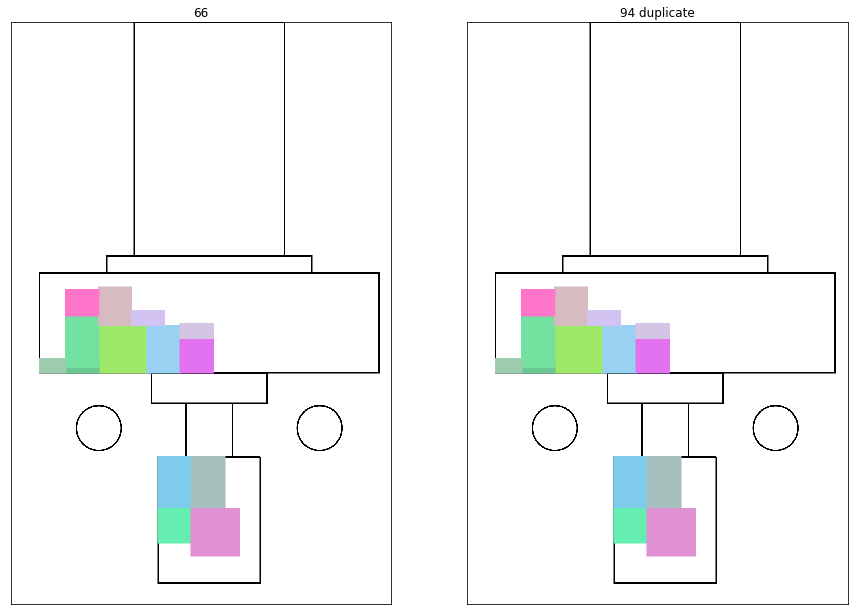

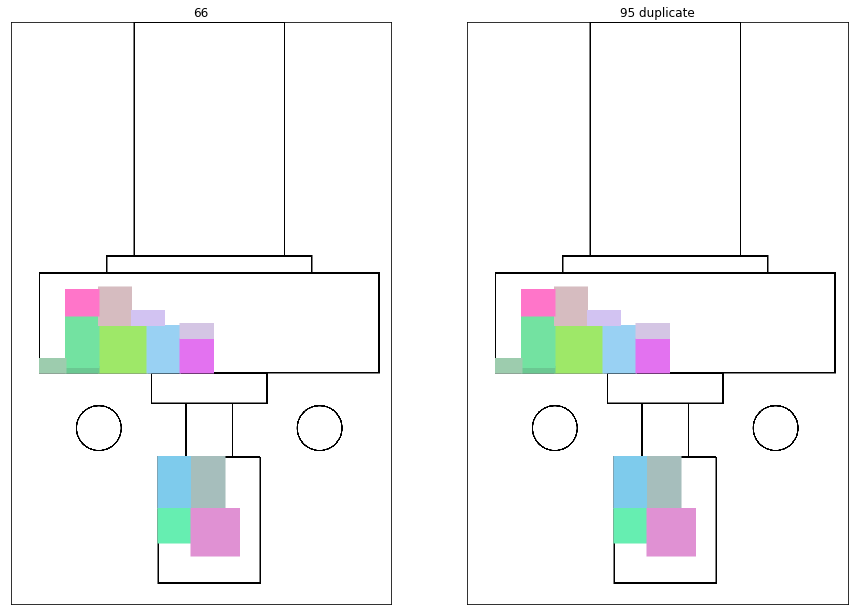

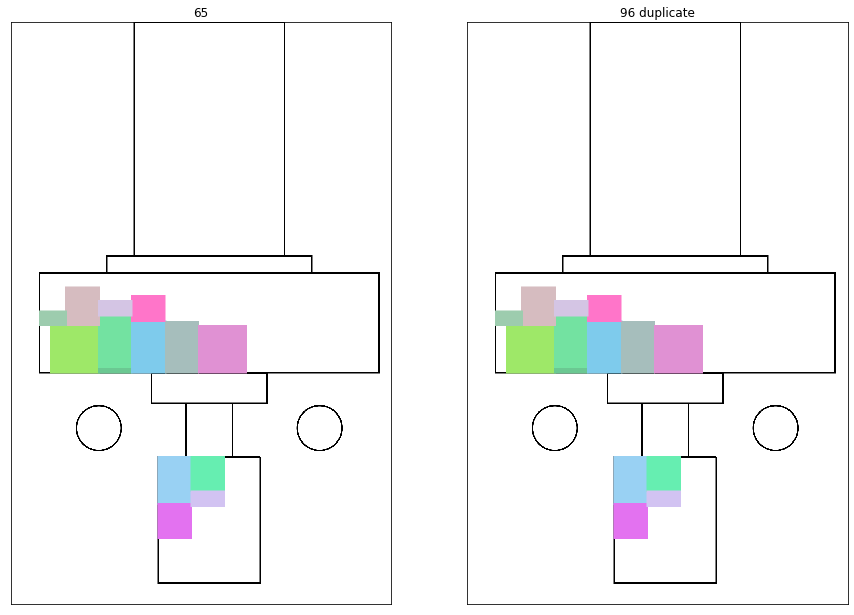

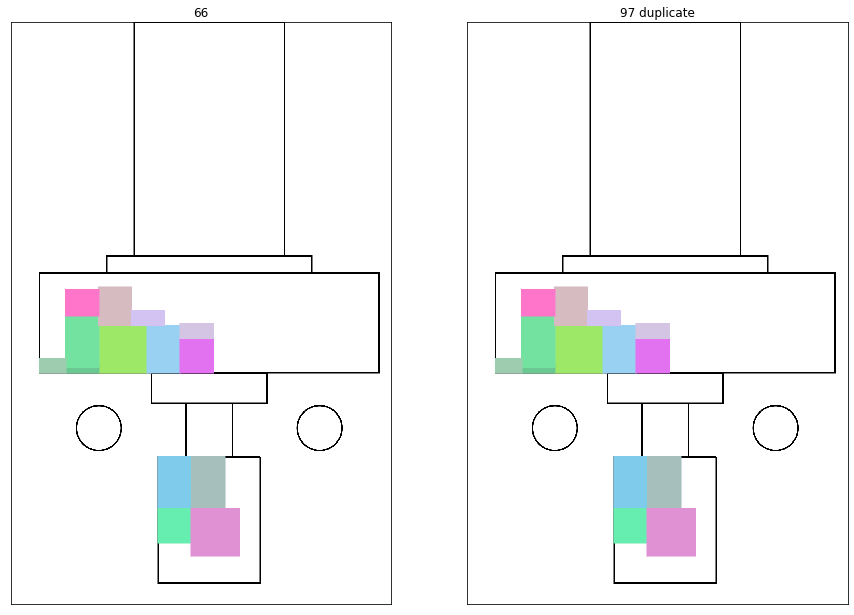

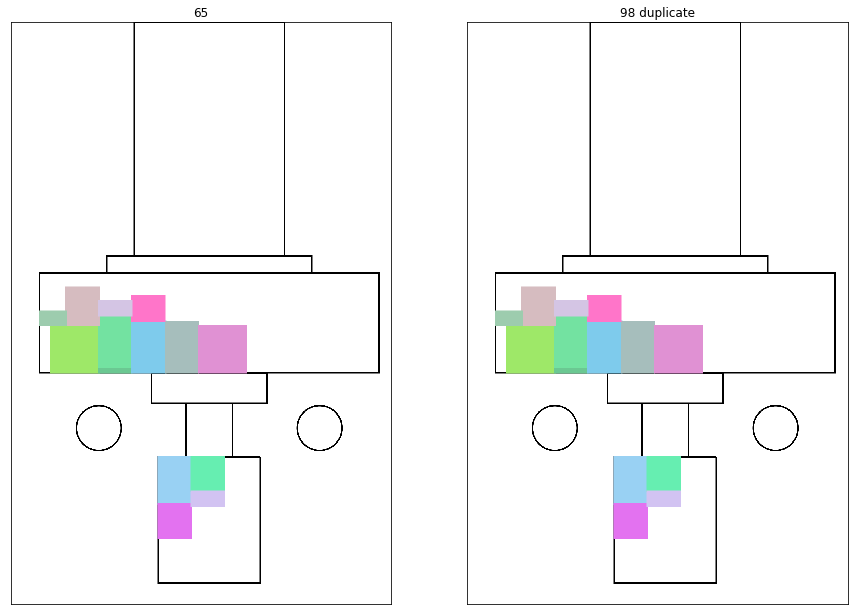

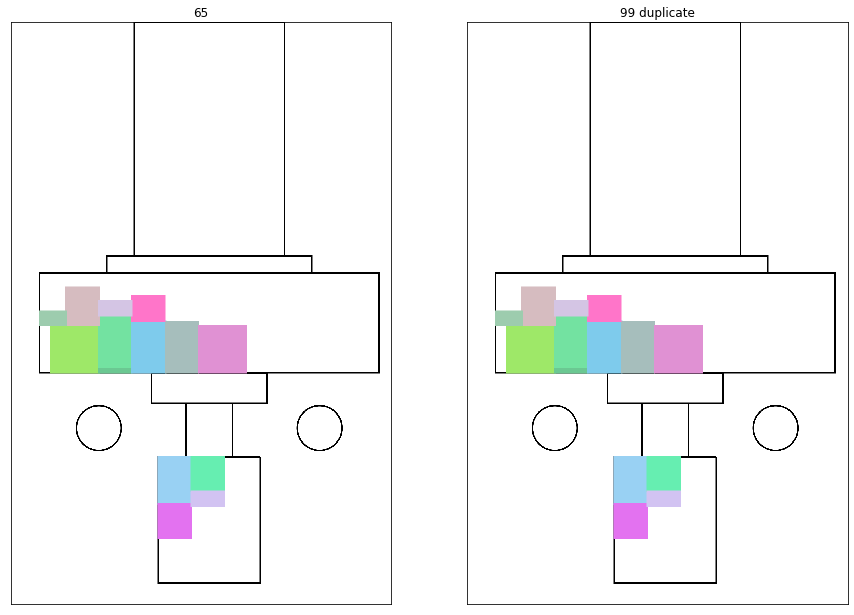

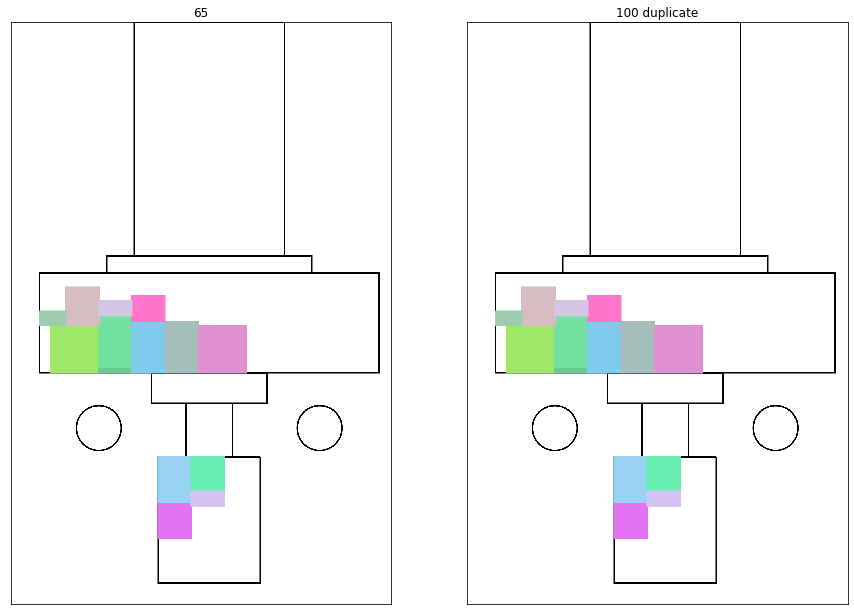

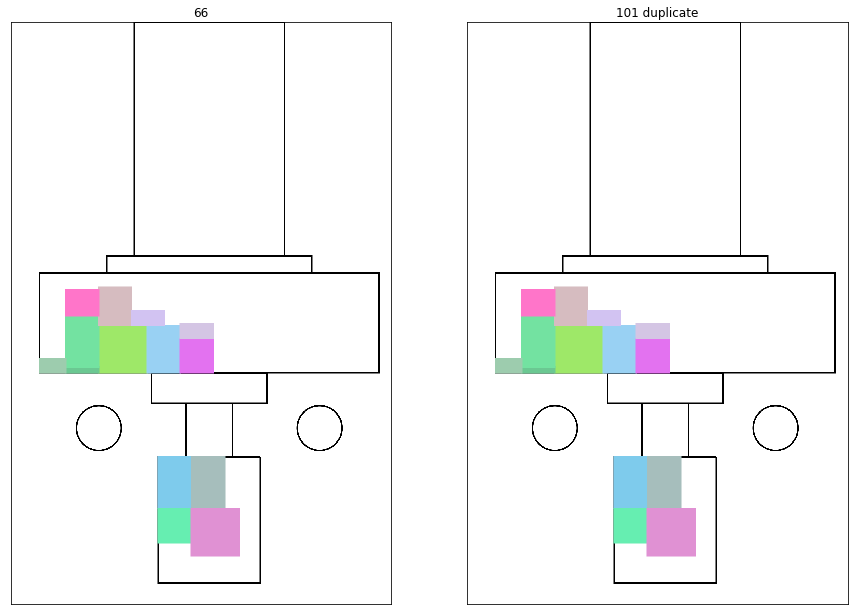

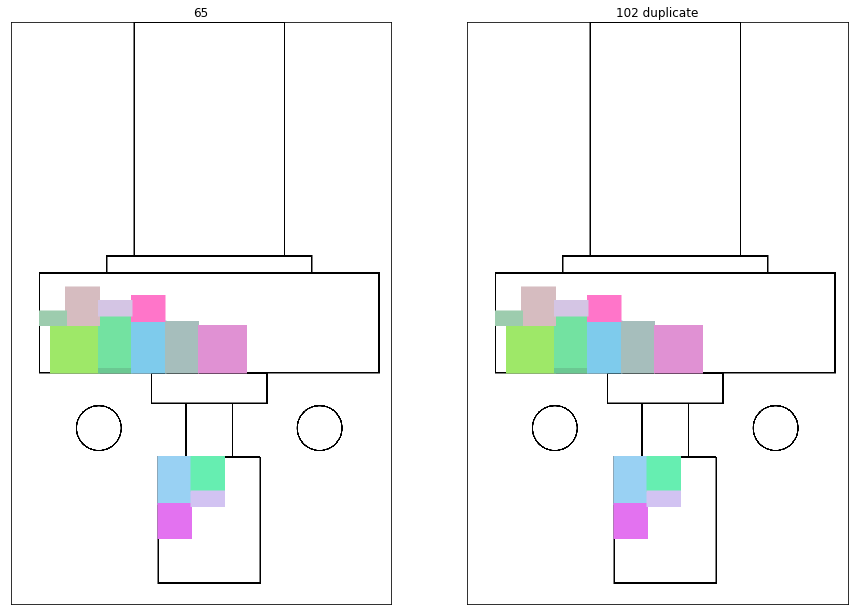

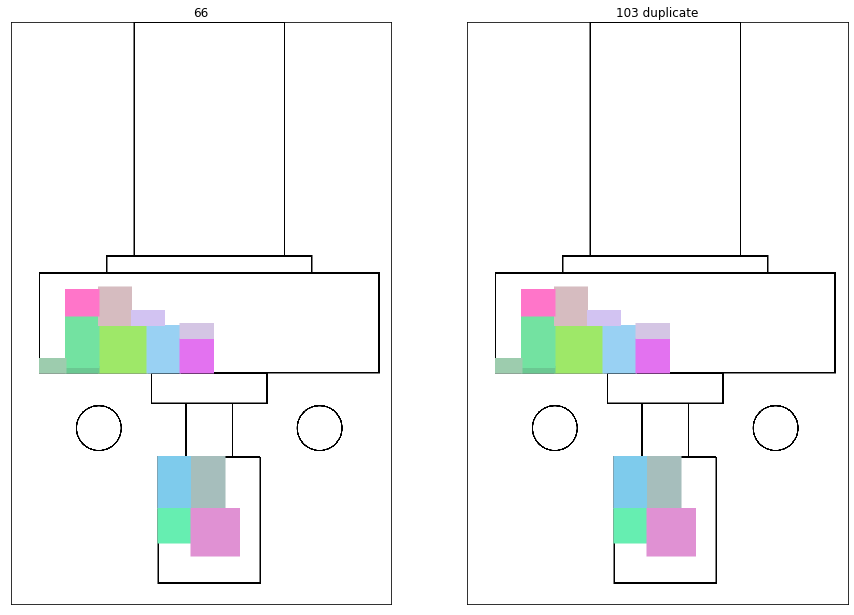

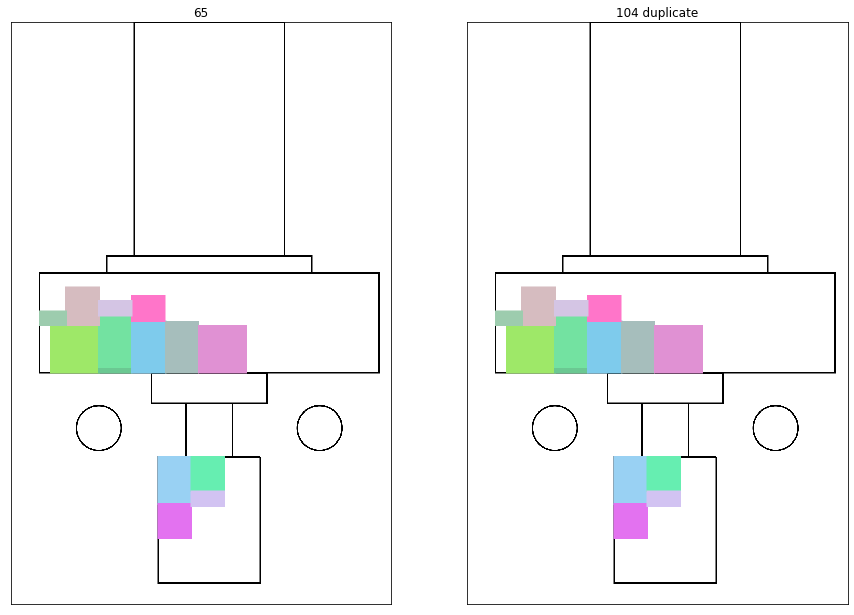

In [43]:
## Display Duplicates
for file_indexes in duplicates[:]:
    try:
    
        plt.subplot(121),plt.imshow(imread(files_list[file_indexes[1]]))
        plt.title(file_indexes[1]), plt.xticks([]), plt.yticks([])

        plt.subplot(122),plt.imshow(imread(files_list[file_indexes[0]]))
        plt.title(str(file_indexes[0]) + ' duplicate'), plt.xticks([]), plt.yticks([])
        plt.show()
    
    except OSError as e:
        continue

In [44]:
# Delete all duplicates save for one
for index in duplicates:
    os.remove(files_list[index[0]])